# Тестовое задание 
Даны участки телеметрии работы оборудования (9 датчиков, 128 сек) соответствующие шести различным режимам. 

## Проанализировать данные, статистики, сделать EDA, визуально посмотреть на разделимость режимов работы известными вам методами.

### Первичная обработка данных

In [334]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import statsmodels as sm
import scipy.stats
from scipy.stats import chisquare
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import precision_score,recall_score,roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import seaborn as sns

In [3]:
X_train = np.load("data/X_train.npy")
Y_train = np.load("data/y_train.npy")
X_test = np.load("data/X_test.npy")
Y_test = np.load("data/y_test.npy")

In [4]:
X_train.shape, X_test.shape

((7352, 128, 9), (2947, 128, 9))

In [5]:
Y_train.shape

(7352, 6)

В тренировочном датасете 7352 измерений, в тестовом 2947.

<code> df['sensor_N'] </code> - показания N-го датчика в течение 128 секунд.

<code> df[M] </code> - принадлежность М-ому режиму.

Каждая строка содержит информацию об одном измерении.

In [6]:
df = pd.DataFrame(
    {'sensor_'+str(k+1): [[X_train[j][i][k] for i in range(128)] for j in range(len(X_train))] for k in range(9)}
)

In [7]:
df2 = pd.DataFrame(
    {'sensor_'+str(k+1): [[X_test[j][i][k] for i in range(128)] for j in range(len(X_test))] for k in range(9)}
)

In [8]:
y = pd.DataFrame(Y_train)

In [7]:
y = y.rename(columns={a: a+1 for a in range(6)})

In [9]:
df.head(5)

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9
0,"[1.012817, 1.022833, 1.0220280000000002, 1.017...","[-0.1232167, -0.1268756, -0.1240037, -0.124927...","[0.1029341, 0.1056872, 0.1021025, 0.1065527, 0...","[0.0001808515, 0.01013856, 0.009275574, 0.0050...","[0.01076681, 0.00657948, 0.008928878000000001,...","[0.05556068, 0.05512483, 0.04840473, 0.0497749...","[0.03019122, 0.04371071, 0.0356878, 0.0404021,...","[0.06601362, 0.04269897, 0.07485018, 0.0573197...","[0.02285864, 0.01031572, 0.01324969, 0.0177512..."
1,"[1.018851, 1.0223799999999998, 1.020781, 1.020...","[-0.123976, -0.1268078, -0.1277862, -0.1266547...","[0.09792958, 0.09935086, 0.09811381, 0.0975171...","[0.001093752, 0.0045500770000000005, 0.0028791...","[-0.0046875879999999995, -0.007487894, -0.0084...","[-0.02685954, -0.02509841, -0.02597534, -0.026...","[0.01711106, 0.02417851, 0.03022889, 0.0320285...","[0.006122796999999999, 0.009710357, 0.01032192...","[0.01226815, 0.01614958, 0.01589471, 0.0126711..."
2,"[1.0231270000000001, 1.021882, 1.0191780000000...","[-0.1200157, -0.1214994, -0.1228407, -0.123717...","[0.09111667, 0.0926756, 0.09606378, 0.09989713...","[0.003531266, 0.002285063, -0.0004197538, -0.0...","[0.004455942, 0.003045876, 0.001776179, 0.0009...","[-0.0059145809999999995, -0.004138910999999999...","[0.02618877, 0.02165149, 0.01455062, 0.0148146...","[-0.000238341, -0.0004275982, 0.000761135, -0....","[0.0021588970000000003, -0.0002724752, 0.00263..."
3,"[1.017682, 1.018149, 1.019854, 1.01988, 1.0191...","[-0.1334039, -0.1343639, -0.1352028, -0.134048...","[0.0951518, 0.09541539, 0.08827355, 0.08632477...","[-0.001772352, -0.0013114479999999998, 0.00038...","[-0.01018541, -0.01125254, -0.0121963, -0.0111...","[0.001053255, 0.001227295, -0.0060043619999999...","[-0.03751574, -0.033097, -0.03036013, -0.02500...","[-0.01288632, -0.01691822, -0.01618518, -0.012...","[-0.0008727416, -0.00548197, -0.00467823, -0.0..."
4,"[1.019952, 1.019616, 1.020933, 1.023061, 1.022...","[-0.1287306, -0.1278461, -0.12823, -0.1298541,...","[0.0808414, 0.07912684, 0.07829138, 0.08406305...","[8.747684999999999e-05, -0.0002719175, 0.00102...","[-0.0038569290000000003, -0.002837935, -0.0030...","[-0.01333336, -0.01494756, -0.01567863, -0.009...","[-0.01942932, -0.01909099, -0.01481631, -0.013...","[-0.008612378, -0.008146719, -0.00537662, -0.0...","[-0.00157401, 0.0002007077, -0.0009700938, -0...."


In [10]:
y.value_counts()

1    2    3    4    5    6  
0.0  0.0  0.0  0.0  0.0  1.0    1407
                    1.0  0.0    1374
               1.0  0.0  0.0    1286
1.0  0.0  0.0  0.0  0.0  0.0    1226
0.0  1.0  0.0  0.0  0.0  0.0    1073
     0.0  1.0  0.0  0.0  0.0     986
dtype: int64

In [11]:
test = pd.DataFrame(Y_test)
test.value_counts()

0  1  2  3  4  5
0  0  0  0  0  1    537
            1  0    532
1  0  0  0  0  0    496
0  0  0  1  0  0    491
   1  0  0  0  0    471
   0  1  0  0  0    420
dtype: int64

Классы имеют небольшой дисбаланс на обучающей выборке, но на тестовой он пропорционален, следовательно при хорошем подборе параметров и модели это не должно влиять на результат.


### Анализ временных рядов

#### Визуальный анализ динамики 

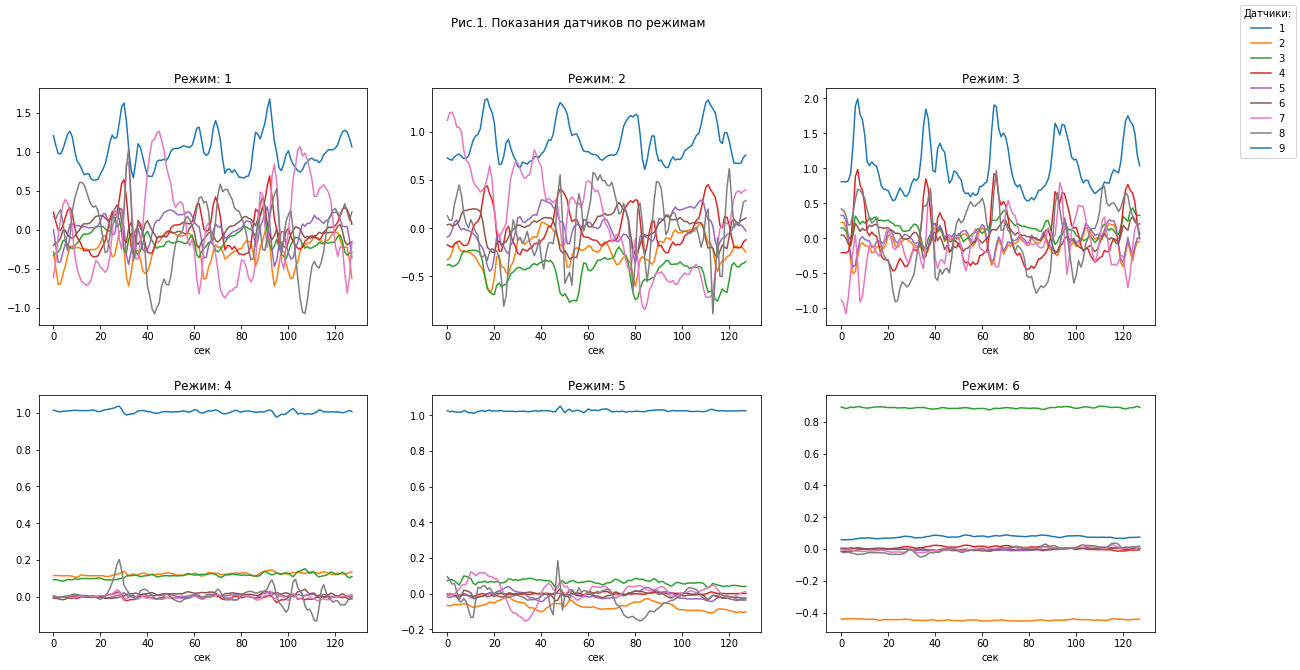

In [12]:
fig = plt.figure(figsize=(20,10))
sensors = range(1,10)
a = 2  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter
for i in range(6):
    sample = df.loc[df[i+1] == 1].sample()
    plt.subplot(a, b, c)
    plt.title('Режим: {}'.format(i+1))
    plt.xlabel('сек')
    for j in range(8):
        plt.plot([X_train[sample['sensor_'+str(j+1)].index[0]][i][j] for i in range(128)])
    c = c + 1
plt.subplots_adjust(wspace=0.2, hspace=0.3)
fig.suptitle('Рис.1. Показания датчиков по режимам')
fig.legend(sensors,title='Датчики:')
plt.show()

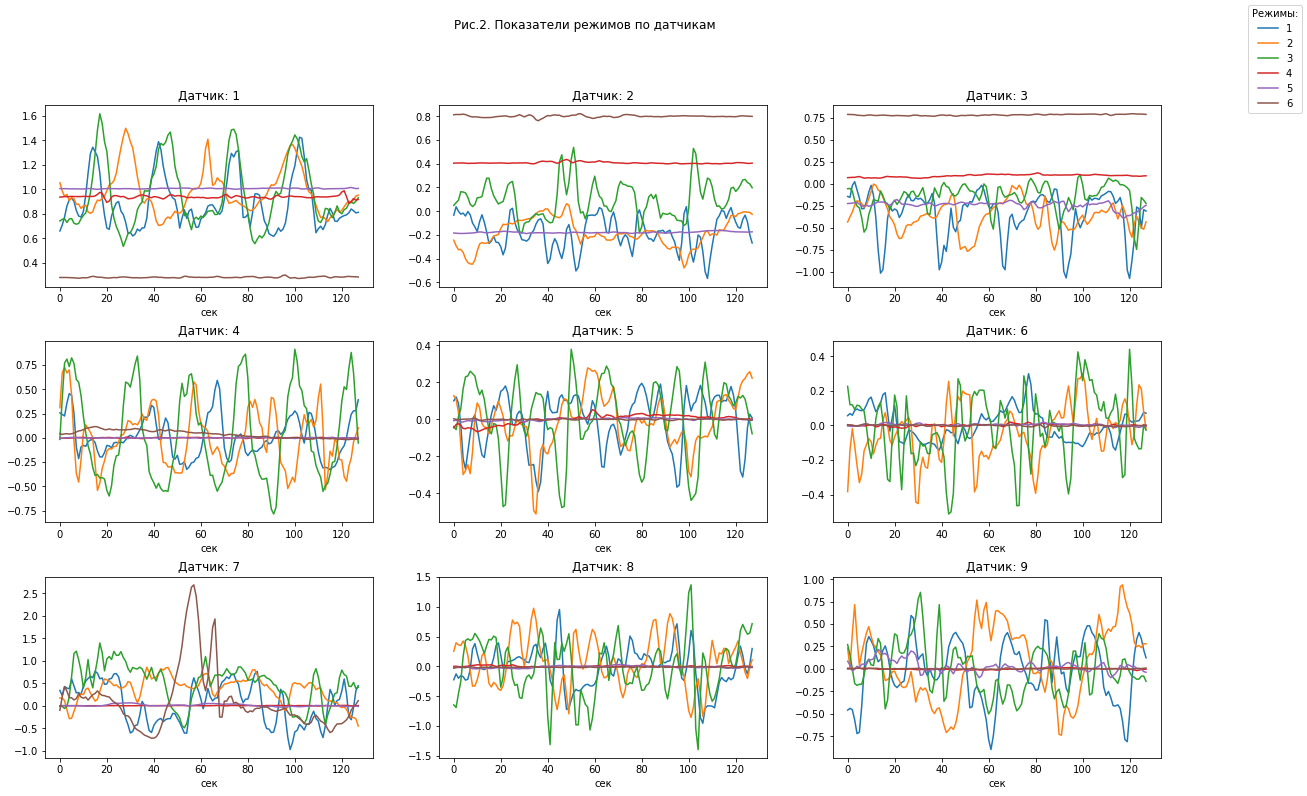

In [14]:
fig = plt.figure(figsize=(20,12))
sensors = range(1,7)
a = 3  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter
for i in range(9):
    plt.subplot(a, b, c)
    plt.title('Датчик: {}'.format(i+1))
    plt.xlabel('сек')
    for j in range(6):
        sample = df.loc[df[j+1] == 1].sample()
        plt.plot([X_train[sample['sensor_'+str(i+1)].index[0]][k][i] for k in range(128)])
    c = c + 1
plt.subplots_adjust(wspace=0.2, hspace=0.3)
fig.suptitle('Рис.2. Показатели режимов по датчикам')
fig.legend(sensors,title='Режимы:')
plt.show()

По визуальному представлению измерений можно сделать следующие выводы:
1. В подавляющем большинстве представленные временные ряды измерений по первым трем режимам стационарные, имеют циклы.
2. Существует четкое различие между первыми и последними тремя режимами, состоящее в размере колебаний амплитудных значений.
3. 6 режим отличается по среднему значению первых трех датчиков от режимов 4 и 5.

Рассмотрим 4, 5 и 6 режим более детально отдельно:

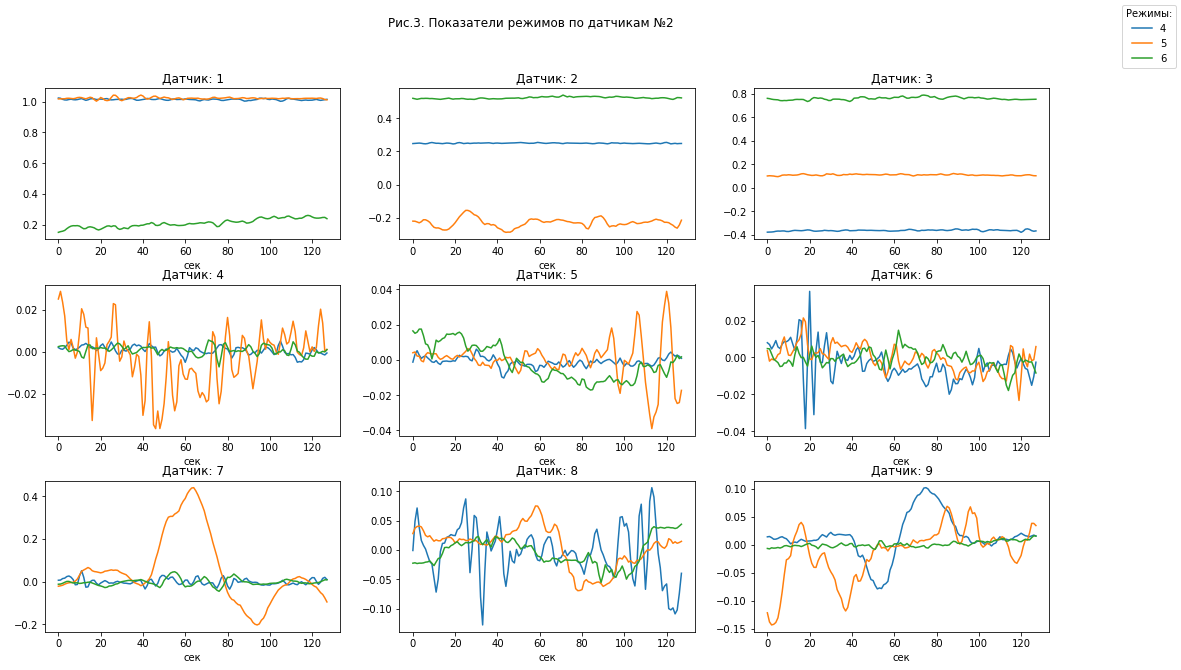

In [15]:
fig = plt.figure(figsize=(18,10))
sensors = range(1,4)
a = 3  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter
for i in range(9):
    plt.subplot(a, b, c)
    plt.title('Датчик: {}'.format(i+1))
    plt.xlabel('сек')
    for j in range(3):
        sample = df.loc[df[j+4] == 1].sample()
        plt.plot([X_train[sample['sensor_'+str(i+1)].index[0]][k][i] for k in range(128)])
    c = c + 1
plt.subplots_adjust(wspace=0.2, hspace=0.3)
fig.suptitle('Рис.3. Показатели режимов по датчикам №2')
fig.legend(list(map(lambda num: num +3, sensors)),title='Режимы:')
plt.show()

1. На первых трех датчиках прослеживаются взаимосвязи между значениями, а также различия между режимами.
2. На некоторых измерениях присутствуют тренд и сезонность.


#### Анализ стационарности


Проверим, есть ли какие-либо различия между распределением стационарных рядов по датчикам по режимам, для этого будет использования расширенный тест на стационарность временного ряда Дики-Фуллера.

In [16]:
inc = 0
test = adfuller(df['sensor_1'][0],regression='ctt',autolag='t-stat')
if test[0]> test[4]['5%']: 
  inc = 1
print(test)

(-4.29101278788959, 0.013037854763556957, 13, 114, {'1%': -4.475762505143283, '5%': -3.8852352892387945, '10%': -3.5858119340633823}, 2.547168438442923)


In [122]:
def get_stat_inc(timeseries):
  inc = 0
  test = adfuller(timeseries,regression='ctt',autolag='t-stat')
  if test[0]> test[4]['5%']: 
      inc = 1
  return inc

In [18]:
stat = [[0]*len(df) for i in range(9)]
for i in tqdm(range(len(df))):
    for j in range(1,10):
      stat[j-1][i] = get_stat_inc(df['sensor_'+str(j)][i])
stat = np.array(stat).T.tolist()

100%|██████████████████████████████████████████████████████████████████████████████| 7352/7352 [05:38<00:00, 21.72it/s]


In [19]:
stationary_stats = []
for j in range(9):
    a = []
    for i in range(len(stat)):
        if stat[i][j] == 0:
            a.append(i)
    stationary_stats.append(df.iloc[a][[6,5,4,3,2,1]].value_counts())
stationary_stats = pd.DataFrame(stationary_stats)
stationary_stats.columns = [1,2,3,4,5,6]
stationary_stats.index +=1

In [20]:
stationary_stats_rel = [stationary_stats[i]/len(df[i]==1) for i  in range(1,7)]
stationary_stats_rel = pd.DataFrame(np.array(stationary_stats_rel).T)
stationary_stats_rel.index +=1
stationary_stats_rel.columns = [1,2,3,4,5,6]
stationary_stats_rel

,1,2,3,4,5,6
1,0.165805,0.141866,0.128808,0.052775,0.078482,0.041077
2,0.130713,0.078210,0.076850,0.056039,0.048014,0.066649
3,0.087051,0.038357,0.044886,0.042573,0.043662,0.054951
4,0.165669,0.141458,0.128808,0.042301,0.066240,0.030740
5,0.129353,0.076850,0.073177,0.043798,0.039989,0.052095
6,0.085555,0.037405,0.044206,0.033188,0.034820,0.044070
7,0.020675,0.021763,0.013466,0.048830,0.051959,0.047334
8,0.033188,0.020947,0.042709,0.034004,0.045702,0.031556
9,0.033596,0.031284,0.061616,0.036589,0.039581,0.044206


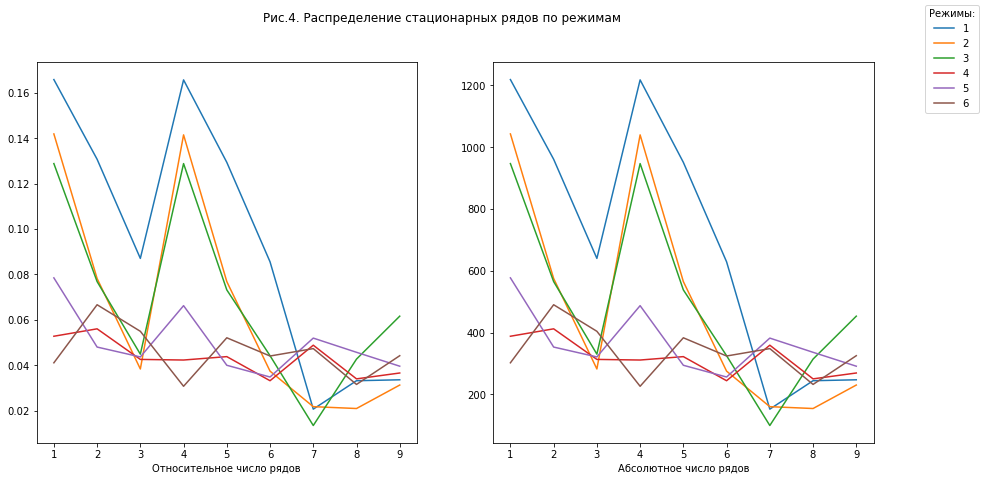

In [21]:
fig = plt.figure(figsize=(15,7))
sensors = range(1,7)
a = 1  # number of rows
b = 2  # number of columns
c = 1
plt.subplot(1,2,1)
for j in sensors:
  plt.plot(stationary_stats_rel[j])
plt.xlabel('Относительное число рядов')
plt.subplot(1,2,2)
for j in sensors:
  plt.plot(stationary_stats[j])

plt.xlabel('Абсолютное число рядов')
plt.subplots_adjust(wspace=0.2, hspace=0.3)
fig.suptitle('Рис.4. Распределение стационарных рядов по режимам')
fig.legend(sensors,title='Режимы:')
plt.show()

По распределению стационарности можно сделать следующие выводы:
1. В абсолютном и относительном соотношении нет больших различий.
2. Первые три режима имеют существенные отличия по стационарности показаний 1, 2, 4, 5 датчиков.
3. Первый режим имеет наибольшие показатели по 1, 2, 4, 5 датчикам.

In [22]:
#Проверим, есть ли статистически значимые различия  между распределениями показателей стационарности:
stationary_stats_conf = [['-']*6 for i in range(6)]
for i in range(6):
    for j in range(6):
        if i != j:
            stationary_stat, p = chisquare(stationary_stats[i+1], stationary_stats[j+1])
            alpha = 0.05
            if p > alpha:
                pass
            else:
                stationary_stats_conf[j-1][i-1] = '+' #Различия есть
        j += 1
stationary_stats_conf = pd.DataFrame(stationary_stats_conf)
stationary_stats_conf.index +=1
stationary_stats_conf.columns = [1,2,3,4,5,6]
stationary_stats_conf

,1,2,3,4,5,6
1,-,+,+,+,+,+
2,+,-,+,+,+,+
3,+,+,-,+,+,+
4,+,+,+,-,+,+
5,+,+,+,+,-,+
6,+,+,+,+,+,-


Различия между режимами по распределению стационарных рядов по датчикам статистически различаются, следовательно это может служить одним из признаков для классификации режимов.

### Статистический анализ

#### Меры центральной тенденции

In [228]:
def get_conf_matrix(metric,column):
    stats_conf = [['-']*6 for i in range(6)]
    for i in range(6):
        for j in range(6):
            if i != j:
                stationary_stat, p = stats.ttest_ind(list((df.loc[y[i+1]==1][column]).apply(metric)), list((df.loc[y[j+1]==1][column]).apply(metric)))
                alpha = 0.05
                if p > alpha:
                    pass
                else:
                    stats_conf[j-1][i-1] = '+' #Различия есть
            j += 1
    stats_conf = pd.DataFrame(stats_conf)
    stats_conf.index +=1
    stats_conf.columns = [1,2,3,4,5,6]
    return stats_conf

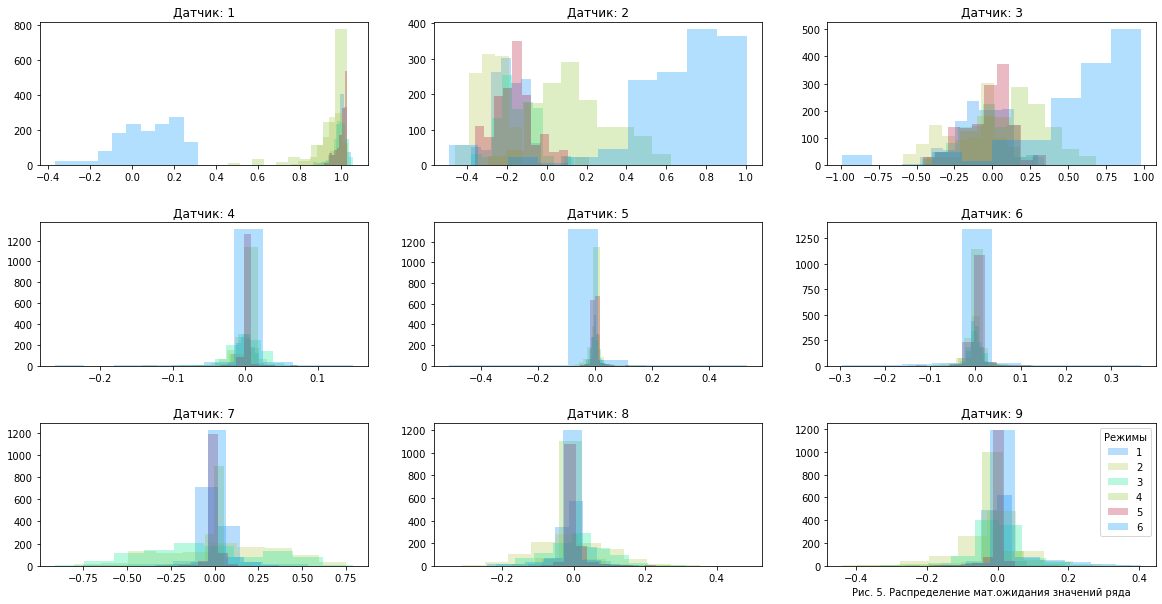

In [229]:
#Матожидание:
fig = plt.figure(figsize=(20,10))
a = 3  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter
for j in range(1,10):
  plt.subplot(a, b, c)
  plt.title('Датчик: {}'.format(j))
  for i in range(1,7):
    plt.hist((df.loc[y[i]==1]['sensor_'+str(j)]).apply(np.mean),fc=(color[i-1].item(0),color[i-1].item(1),color[i-1].item(2), 0.3))
  c = c + 1
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.legend(range(1,7),title='Режимы')
plt.xlabel('Рис. 5. Распределение мат.ожидания значений ряда')
plt.show()

In [231]:
#Проверим, есть ли статистически значимые различия  между распределениями мат.ожиданий
for i in range(1,10):
    print('Датчик №'+str(i), get_conf_matrix(np.mean,'sensor_'+str(i)),sep='\n')

Датчик №1
   1  2  3  4  5  6
1  -  +  -  +  +  +
2  +  -  +  +  +  +
3  -  +  -  +  +  +
4  +  +  +  -  +  +
5  +  +  +  +  -  +
6  +  +  +  +  +  -
Датчик №2
   1  2  3  4  5  6
1  -  +  +  +  +  +
2  +  -  +  +  +  +
3  +  +  -  +  +  +
4  +  +  +  -  +  +
5  +  +  +  +  -  +
6  +  +  +  +  +  -
Датчик №3
   1  2  3  4  5  6
1  -  +  +  +  +  +
2  +  -  +  +  +  +
3  +  +  -  +  +  +
4  +  +  +  -  +  +
5  +  +  +  +  -  +
6  +  +  +  +  +  -
Датчик №4
   1  2  3  4  5  6
1  -  +  +  +  -  +
2  +  -  +  +  +  +
3  +  +  -  +  -  -
4  +  +  +  -  +  +
5  -  +  -  +  -  +
6  +  +  -  +  +  -
Датчик №5
   1  2  3  4  5  6
1  -  +  +  +  +  +
2  +  -  +  -  -  -
3  +  +  -  +  +  +
4  +  -  +  -  -  +
5  +  -  +  -  -  -
6  +  -  +  +  -  -
Датчик №6
   1  2  3  4  5  6
1  -  +  +  +  +  +
2  +  -  -  -  -  -
3  +  -  -  -  -  -
4  +  -  -  -  -  -
5  +  -  -  -  -  -
6  +  -  -  -  -  -
Датчик №7
   1  2  3  4  5  6
1  -  +  +  +  +  +
2  +  -  +  +  +  +
3  +  +  -  +  +  -
4  +  +  +

1. Значения мат.ожиданий между режимами в большинстве статистически значимы.
2. На шестом датчике первый режим существенно отличается от остальных.

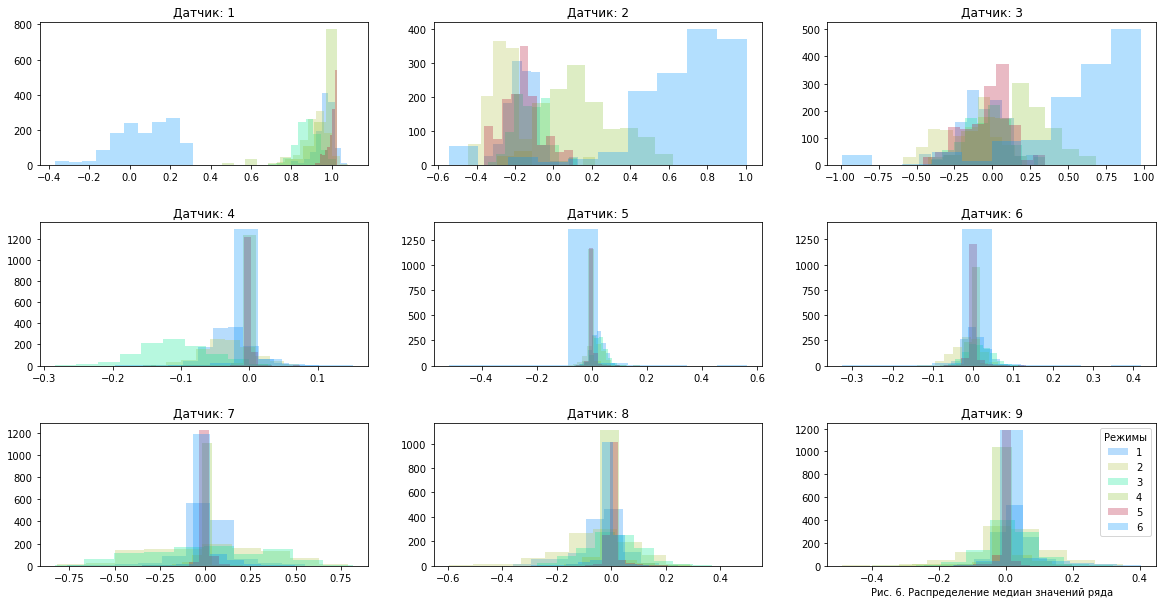

In [236]:
fig = plt.figure(figsize=(20,10))
a = 3  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter
for j in range(1,10):
    plt.subplot(a, b, c)
    plt.title('Датчик: {}'.format(j))
    for i in range(1,7):
        plt.hist((df.loc[y[i]==1]['sensor_'+str(j)]).apply(np.median),fc=(color[i-1].item(0),color[i-1].item(1),color[i-1].item(2), 0.3))
    c = c + 1
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.legend(range(1,7),title='Режимы')
plt.xlabel('Рис. 6. Распределение медиан значений ряда')
plt.show()

In [238]:
for i in range(1,10):
    print('Датчик №'+str(i), get_conf_matrix(np.median,'sensor_'+str(i)),sep='\n')

Датчик №1
   1  2  3  4  5  6
1  -  +  +  +  +  +
2  +  -  +  +  +  +
3  +  +  -  +  +  +
4  +  +  +  -  +  +
5  +  +  +  +  -  +
6  +  +  +  +  +  -
Датчик №2
   1  2  3  4  5  6
1  -  +  +  +  +  +
2  +  -  +  +  +  +
3  +  +  -  +  +  +
4  +  +  +  -  +  -
5  +  +  +  +  -  +
6  +  +  +  -  +  -
Датчик №3
   1  2  3  4  5  6
1  -  +  +  +  +  +
2  +  -  +  -  +  +
3  +  +  -  +  +  +
4  +  -  +  -  +  +
5  +  +  +  +  -  +
6  +  +  +  +  +  -
Датчик №4
   1  2  3  4  5  6
1  -  +  +  +  +  +
2  +  -  +  +  +  +
3  +  +  -  +  -  +
4  +  +  +  -  +  +
5  +  +  -  +  -  +
6  +  +  +  +  +  -
Датчик №5
   1  2  3  4  5  6
1  -  +  +  +  +  +
2  +  -  +  +  +  +
3  +  +  -  +  +  +
4  +  +  +  -  -  +
5  +  +  +  -  -  +
6  +  +  +  +  +  -
Датчик №6
   1  2  3  4  5  6
1  -  +  +  +  +  +
2  +  -  +  +  +  +
3  +  +  -  -  -  +
4  +  +  -  -  -  +
5  +  +  -  -  -  +
6  +  +  +  +  +  -
Датчик №7
   1  2  3  4  5  6
1  -  -  +  -  -  -
2  -  -  -  -  -  -
3  +  -  -  +  +  +
4  -  -  +

1. Значения медиан между режимами в большинстве статистически значимы.
2. На седьмом датчике третий режим существенно отличается от остальных.

#### Меры разброса

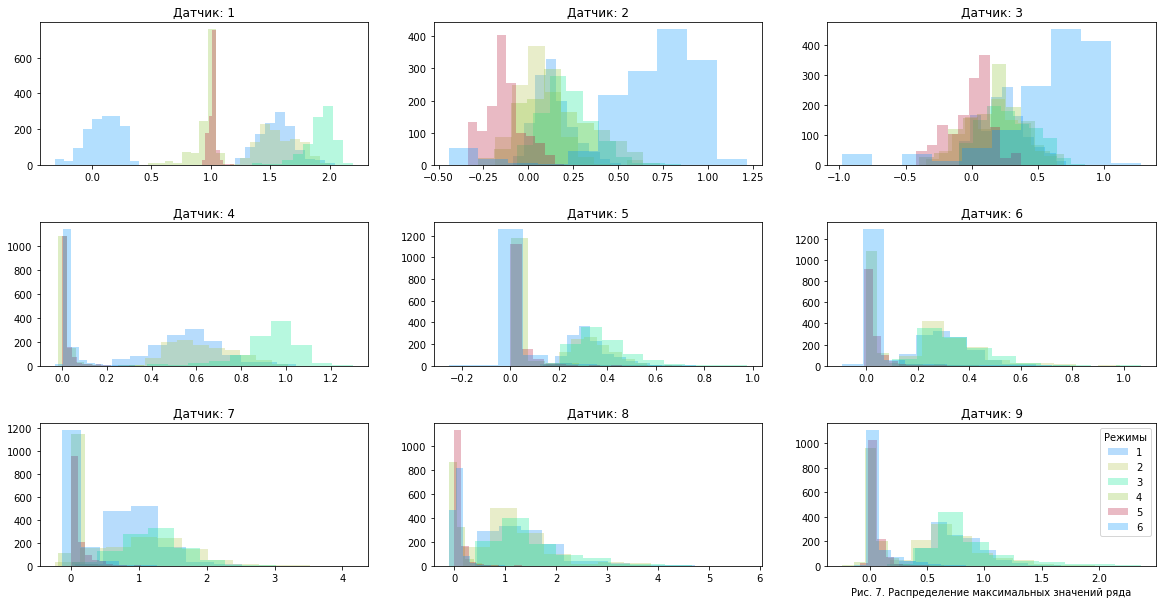

In [240]:
#Максимальное значение:
fig = plt.figure(figsize=(20,10))
a = 3  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter

for j in range(1,10):
  plt.subplot(a, b, c)
  plt.title('Датчик: {}'.format(j))
  for i in range(1,7):
    plt.hist((df.loc[y[i]==1]['sensor_'+str(j)]).apply(max),fc=(color[i-1][0],color[i-1][1],color[i-1][2],0.3))
  c = c + 1
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.legend(range(1,7),title='Режимы')
plt.xlabel('Рис. 7. Распределение максимальных значений ряда')
plt.show()

In [242]:
for i in range(1,10):
    print('Датчик №'+str(i), get_conf_matrix(max,'sensor_'+str(i)),sep='\n')

Датчик №1
   1  2  3  4  5  6
1  -  +  +  +  +  +
2  +  -  +  +  +  +
3  +  +  -  +  +  +
4  +  +  +  -  +  +
5  +  +  +  +  -  +
6  +  +  +  +  +  -
Датчик №2
   1  2  3  4  5  6
1  -  +  +  +  +  +
2  +  -  +  +  +  +
3  +  +  -  +  +  +
4  +  +  +  -  +  +
5  +  +  +  +  -  +
6  +  +  +  +  +  -
Датчик №3
   1  2  3  4  5  6
1  -  +  -  +  +  +
2  +  -  +  +  +  +
3  -  +  -  +  +  +
4  +  +  +  -  +  +
5  +  +  +  +  -  +
6  +  +  +  +  +  -
Датчик №4
   1  2  3  4  5  6
1  -  +  +  +  +  +
2  +  -  +  +  +  +
3  +  +  -  +  +  +
4  +  +  +  -  +  +
5  +  +  +  +  -  +
6  +  +  +  +  +  -
Датчик №5
   1  2  3  4  5  6
1  -  +  +  +  +  +
2  +  -  +  +  +  +
3  +  +  -  -  -  +
4  +  +  -  -  -  +
5  +  +  -  -  -  +
6  +  +  +  +  +  -
Датчик №6
   1  2  3  4  5  6
1  -  -  +  +  +  +
2  -  -  +  +  +  +
3  +  +  -  -  -  +
4  +  +  -  -  -  +
5  +  +  -  -  -  +
6  +  +  +  +  +  -
Датчик №7
   1  2  3  4  5  6
1  -  -  +  +  +  +
2  -  -  +  +  +  +
3  +  +  -  +  +  +
4  +  +  +

Значения максимумов между режимами в большинстве статистически значимы

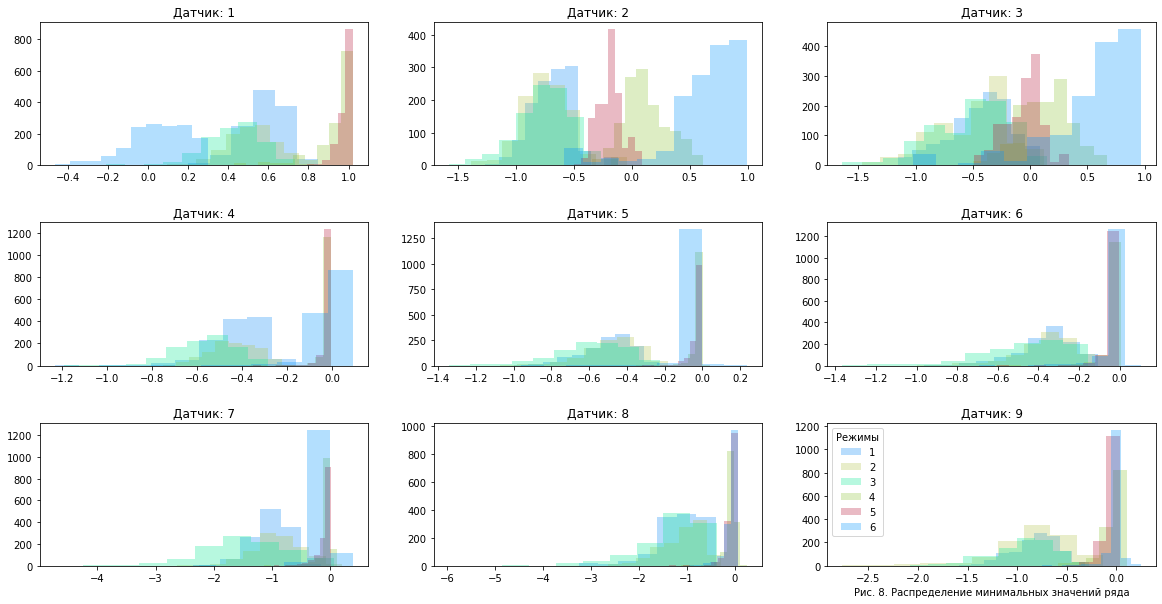

In [244]:
#Минимальное значение:
fig = plt.figure(figsize=(20,10))
a = 3  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter

for j in range(1,10):
  plt.subplot(a, b, c)
  plt.title('Датчик: {}'.format(j))
  for i in range(1,7):
    plt.hist((df.loc[y[i]==1]['sensor_'+str(j)]).apply(min),fc=(color[i-1][0],color[i-1][1],color[i-1][2],0.3))
  c = c + 1
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.legend(range(1,7),title='Режимы')
plt.xlabel('Рис. 8. Распределение минимальных значений ряда')
plt.show()

In [245]:
for i in range(1,10):
    print('Датчик №'+str(i), get_conf_matrix(min,'sensor_'+str(i)),sep='\n')

Датчик №1
   1  2  3  4  5  6
1  -  +  +  +  +  +
2  +  -  +  +  +  +
3  +  +  -  +  +  +
4  +  +  +  -  +  +
5  +  +  +  +  -  +
6  +  +  +  +  +  -
Датчик №2
   1  2  3  4  5  6
1  -  -  +  +  +  +
2  -  -  +  +  +  +
3  +  +  -  +  +  +
4  +  +  +  -  +  +
5  +  +  +  +  -  +
6  +  +  +  +  +  -
Датчик №3
   1  2  3  4  5  6
1  -  -  +  +  +  +
2  -  -  +  +  +  +
3  +  +  -  +  +  +
4  +  +  +  -  +  +
5  +  +  +  +  -  +
6  +  +  +  +  +  -
Датчик №4
   1  2  3  4  5  6
1  -  +  +  +  +  +
2  +  -  +  +  +  +
3  +  +  -  -  +  +
4  +  +  -  -  +  +
5  +  +  +  +  -  +
6  +  +  +  +  +  -
Датчик №5
   1  2  3  4  5  6
1  -  +  +  +  +  +
2  +  -  +  +  +  +
3  +  +  -  +  +  +
4  +  +  +  -  -  +
5  +  +  +  -  -  +
6  +  +  +  +  +  -
Датчик №6
   1  2  3  4  5  6
1  -  +  +  +  +  -
2  +  -  +  +  +  +
3  +  +  -  -  -  +
4  +  +  -  -  -  +
5  +  +  -  -  -  +
6  -  +  +  +  +  -
Датчик №7
   1  2  3  4  5  6
1  -  +  +  +  +  +
2  +  -  +  +  +  +
3  +  +  -  +  -  +
4  +  +  +

Значения минимумов между режимами в большинстве статистически значимы

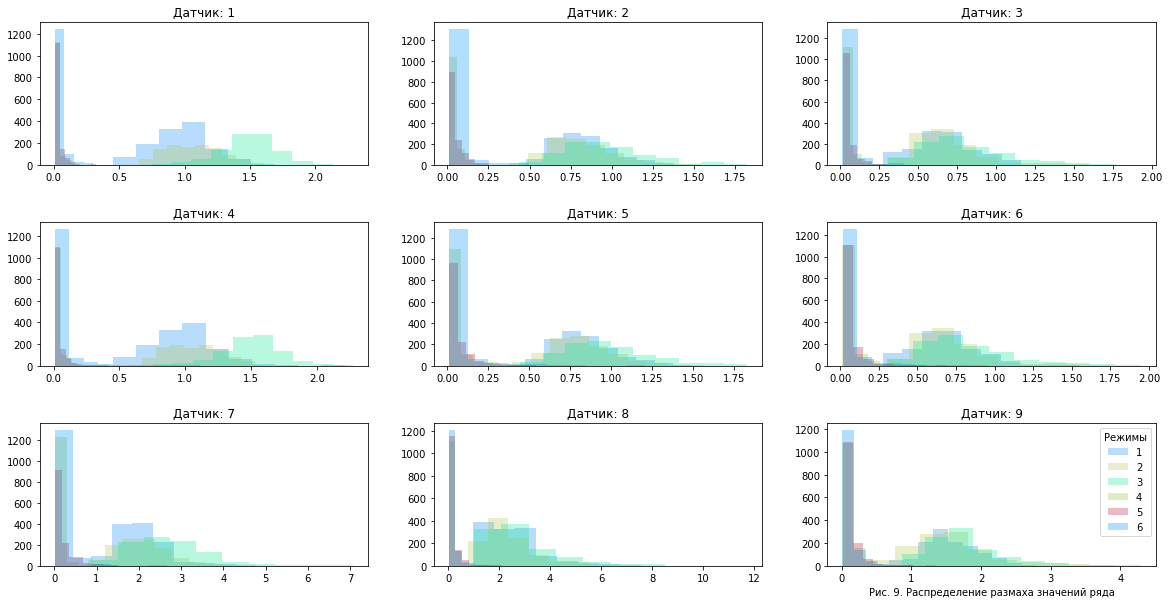

In [247]:
#Размах:
fig = plt.figure(figsize=(20,10))
a = 3  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter

for j in range(1,10):
  plt.subplot(a, b, c)
  plt.title('Датчик: {}'.format(j))
  for i in range(1,7):
    plt.hist((df.loc[y[i]==1]['sensor_'+str(j)]).apply(max)-(df.loc[y[i]==1]['sensor_'+str(j)]).apply(min),fc=(color[i-1][0],color[i-1][1],color[i-1][2],0.3))
  c = c + 1
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.legend(range(1,7),title='Режимы')
plt.xlabel('Рис. 9. Распределение размаха значений ряда')
plt.show()

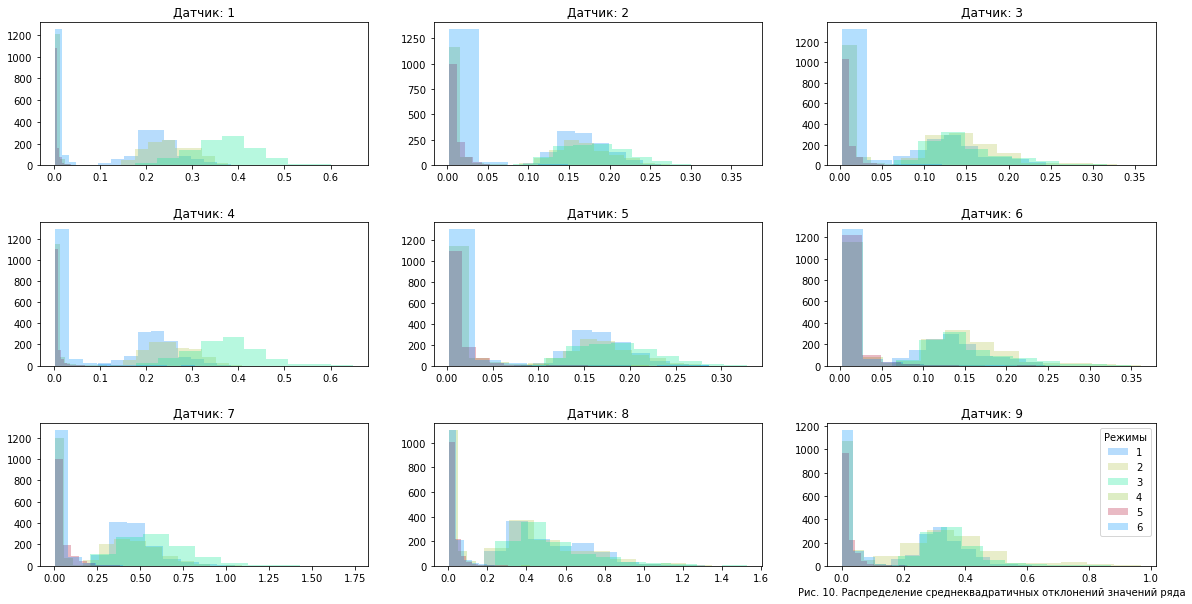

In [249]:
#Среднеквадратичное отклонение:
fig = plt.figure(figsize=(20,10))
a = 3  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter

for j in range(1,10):
  plt.subplot(a, b, c)
  plt.title('Датчик: {}'.format(j))
  for i in range(1,7):
    plt.hist((df.loc[y[i]==1]['sensor_'+str(j)]).apply(np.std),fc=(color[i-1][0],color[i-1][1],color[i-1][2],0.3))
  c = c + 1
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.legend(range(1,7),title='Режимы')
plt.xlabel('Рис. 10. Распределение среднеквадратичных отклонений значений ряда')
plt.show()

In [250]:
for i in range(1,10):
    print('Датчик №'+str(i), get_conf_matrix(np.std,'sensor_'+str(i)),sep='\n')

Датчик №1
   1  2  3  4  5  6
1  -  +  +  +  +  +
2  +  -  +  +  +  +
3  +  +  -  -  +  +
4  +  +  -  -  +  +
5  +  +  +  +  -  +
6  +  +  +  +  +  -
Датчик №2
   1  2  3  4  5  6
1  -  +  +  +  +  -
2  +  -  +  +  +  +
3  +  +  -  +  +  +
4  +  +  +  -  -  +
5  +  +  +  -  -  +
6  -  +  +  +  +  -
Датчик №3
   1  2  3  4  5  6
1  -  -  +  +  +  +
2  -  -  +  +  +  +
3  +  +  -  -  -  +
4  +  +  -  -  -  +
5  +  +  -  -  -  +
6  +  +  +  +  +  -
Датчик №4
   1  2  3  4  5  6
1  -  +  +  +  +  +
2  +  -  +  +  +  +
3  +  +  -  -  +  +
4  +  +  -  -  +  +
5  +  +  +  +  -  +
6  +  +  +  +  +  -
Датчик №5
   1  2  3  4  5  6
1  -  +  +  +  +  +
2  +  -  +  +  +  +
3  +  +  -  -  -  +
4  +  +  -  -  -  +
5  +  +  -  -  -  +
6  +  +  +  +  +  -
Датчик №6
   1  2  3  4  5  6
1  -  +  +  +  +  +
2  +  -  +  +  +  +
3  +  +  -  -  -  +
4  +  +  -  -  -  +
5  +  +  -  -  -  +
6  +  +  +  +  +  -
Датчик №7
   1  2  3  4  5  6
1  -  +  +  +  +  -
2  +  -  +  +  +  +
3  +  +  -  +  +  +
4  +  +  +

Значения среднеквадратичных отклонений между режимами в большинстве статистически значимы

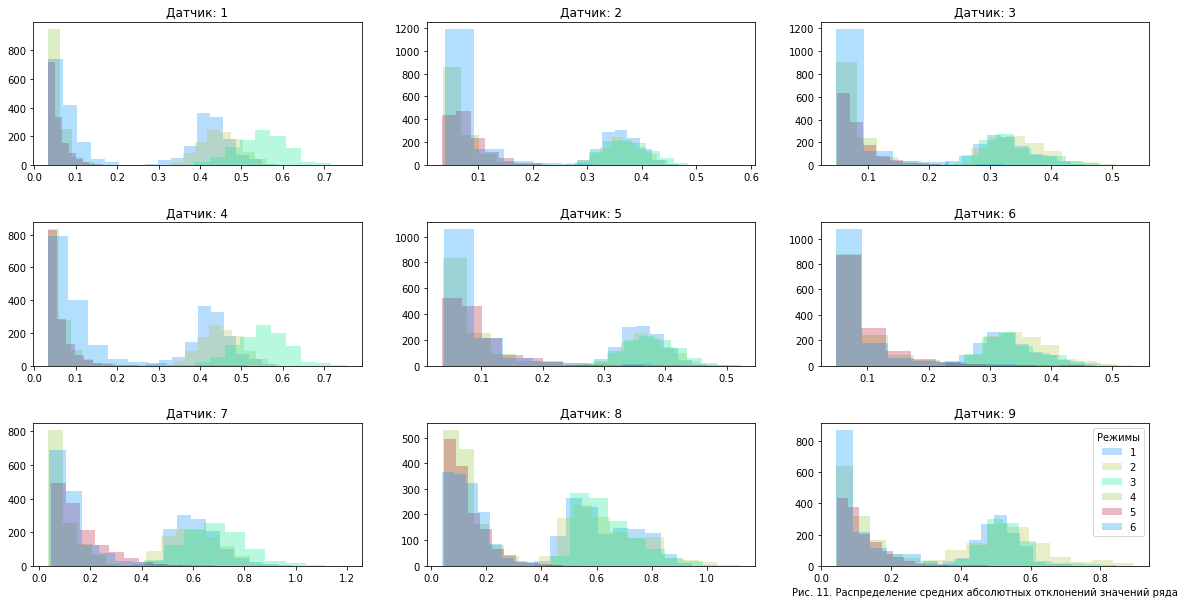

In [252]:
def mad(data, axis=None):
    return np.mean(np.absolute(data - np.mean(data, axis)), axis)
    np.median(np.absolute(x - np.median(x)))
#Среднеквадратичное отклонение:
fig = plt.figure(figsize=(20,10))
a = 3  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter

for j in range(1,10):
  plt.subplot(a, b, c)
  plt.title('Датчик: {}'.format(j))
  for i in range(1,7):
    plt.hist(np.sqrt((df.loc[y[i]==1]['sensor_'+str(j)]).apply(mad)),fc=(color[i-1][0],color[i-1][1],color[i-1][2],0.3))
  c = c + 1
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.legend(range(1,7),title='Режимы')
plt.xlabel('Рис. 11. Распределение средних абсолютных отклонений значений ряда')
plt.show()

In [253]:
for i in range(1,10):
    print('Датчик №'+str(i), get_conf_matrix(mad,'sensor_'+str(i)),sep='\n')

Датчик №1
   1  2  3  4  5  6
1  -  +  +  +  +  +
2  +  -  +  +  +  +
3  +  +  -  -  +  +
4  +  +  -  -  +  +
5  +  +  +  +  -  +
6  +  +  +  +  +  -
Датчик №2
   1  2  3  4  5  6
1  -  +  +  +  +  +
2  +  -  +  +  +  +
3  +  +  -  +  +  +
4  +  +  +  -  -  +
5  +  +  +  -  -  +
6  +  +  +  +  +  -
Датчик №3
   1  2  3  4  5  6
1  -  +  +  +  +  +
2  +  -  +  +  +  +
3  +  +  -  -  -  +
4  +  +  -  -  -  +
5  +  +  -  -  -  +
6  +  +  +  +  +  -
Датчик №4
   1  2  3  4  5  6
1  -  +  +  +  +  +
2  +  -  +  +  +  +
3  +  +  -  +  +  +
4  +  +  +  -  +  +
5  +  +  +  +  -  +
6  +  +  +  +  +  -
Датчик №5
   1  2  3  4  5  6
1  -  +  +  +  +  +
2  +  -  +  +  +  +
3  +  +  -  -  -  +
4  +  +  -  -  -  +
5  +  +  -  -  -  +
6  +  +  +  +  +  -
Датчик №6
   1  2  3  4  5  6
1  -  +  +  +  +  +
2  +  -  +  +  +  +
3  +  +  -  -  -  +
4  +  +  -  -  -  +
5  +  +  -  -  -  +
6  +  +  +  +  +  -
Датчик №7
   1  2  3  4  5  6
1  -  +  +  +  +  -
2  +  -  +  +  +  +
3  +  +  -  +  +  +
4  +  +  +

1. Значения средних абсолютных отклонений между режимами в большинстве статистически значимы.
2. 3, 4 и 5 режим на 3, 5, 6, 8, 9 датчиках имеют схожие распределения.

Рассмотрим далее, как взаимосвязаны значения датчиков между собой.

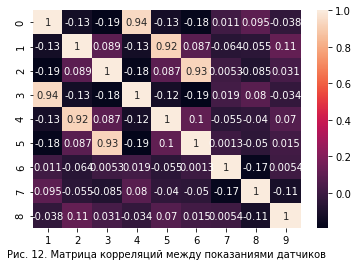

In [333]:
corr = pd.DataFrame(np.array([df.iloc[0]['sensor_'+str(i)] for i in range(1,10)]).T).corr()
corr.columns = [1,2,3,4,5,6,7,8,9]
for j in range(len(df)):
    sensor_corr = pd.DataFrame(np.array([df.iloc[j]['sensor_'+str(i)] for i in range(1,10)]).T).corr()
    sensor_corr.columns = [1,2,3,4,5,6,7,8,9]
    corr += sensor_corr
sns.heatmap(corr/7353,annot=True)
plt.xlabel('Рис. 12. Матрица корреляций между показаниями датчиков')
plt.show()

Ярко выражена попарная связь между показаниями датчиков 1 и 4, 2 и 5, 3 и 6.

### Анализ преобразования Фурье

Так как любой сигнал можно разложить в тригонометрические функции, применим дискретное преобразование Фурье и проанализируем различия:

In [10]:
from scipy.fft import fft, fftfreq

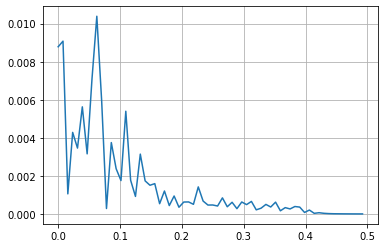

In [206]:
#Пример распределения частот 
N = 128
T = 1.0 / 1
yf = fft(df['sensor_7'][9])
xf = fftfreq(N, T)[:N//2]

plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

In [81]:
#Усредним значения частот по режимам и датчикам
yf_fft = [[0]*6 for i in range(9)]
for n in range(1,10):
    for i in range(6):
        yf = [0]*64
        for j in range(len(df.loc[y[1]==1])):
            yf = [a + b for a, b in zip(yf,2.0/N * np.abs(fft(df['sensor_'+str(n)][j])[0:N//2]))]
        yf_fft[n-1][i] = [yf[k]/len(df.loc[y[i]==1]) for k in range(len(yf))]

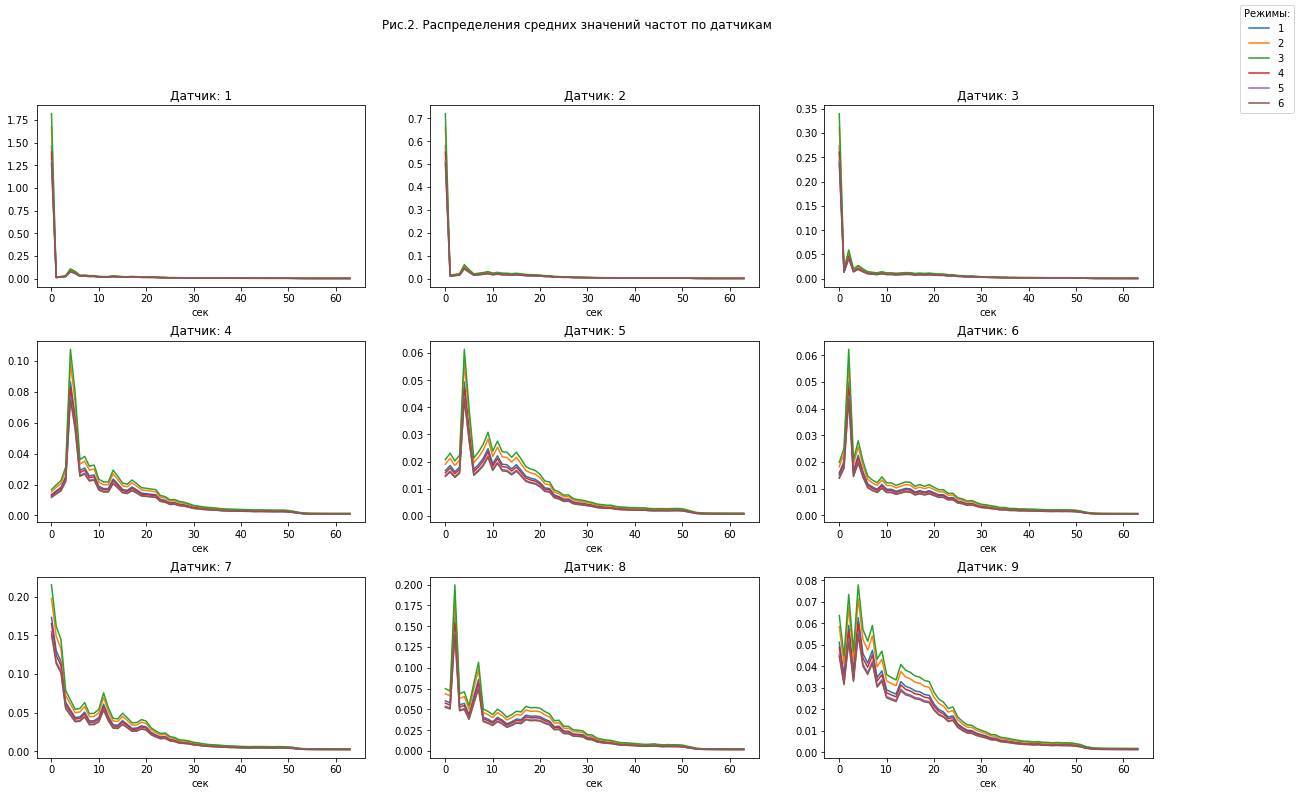

In [80]:
fig = plt.figure(figsize=(20,12))
sensors = range(1,7)
a = 3  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter
for i in range(9):
    plt.subplot(a, b, c)
    plt.title('Датчик: {}'.format(i+1))
    plt.xlabel('сек')
    for j in range(6):
        plt.plot(yf_fft[i][j])
    c = c + 1
plt.subplots_adjust(wspace=0.2, hspace=0.3)
fig.suptitle('Рис.2. Распределения средних значений частот по датчикам')
fig.legend(sensors,title='Режимы:')
plt.show()

Все сигналы имеют схожу структуру, но различны по амплитудному значению, что более отчетливо видно на последних 6 датчиках.

Если учитывать в качестве признаков все амплитуды, качество классификации сильно падает, что скорее всего связано с разреженностью данных.

Если учитывать в качестве признаков только пиковые амплитуды, качество немного повышается, но остается на критически низком уровне, особенно на 2,5 и 6 режимах.

Низкие показатели возможно связаны с тем, что мы учитываем сразу несколько различной природы показателей.

## Сделать фичи, которые имеют не black-box смысл. Прокомментировать выбор фичей, какой смысл они несут и как могут помочь в решении задачи.

Исходя из анализа из предыдущего раздела, для классификации будут использованы следующие наборы признаков:
* Основанные на анализе временных рядов:  индикаторы стационарности временного ряда (так как были получены статистически значимые различия по критерию Пирсона, а также в абсолютном значении количество стационарных рядов различалось от режима к режиму, что может говорить о том, что одни режимы более стабильны, а другие характеризуются большим объемов переходных процессов в природе сигнала)
* Показатели частотного анализа (амплитудные значения синусоидальных сигналов дискретного преобразования Фурье - как частотная характеристика сигнала)
* Статистические показатели (мат.ожидание, медиана, максимальные и минимальные значения, среднеквадратичное отклонение, размах, среднее абсолютное отклонение - как точечные оценки процессов в сигнале)
* Интервальные оценки статистик (Для учета динамики временных рядов. В данном случае можно взглянуть на несколько облегченную версию: разделить каждый временной ряд на 8 равных участков по 16 секунд и расчитать на каждом его статистики, полученные для целого ряда в предыдущих частях анализа. Это позволит учесть динамику распределения оценок, но не сильно усложнит вычисления, как например учет всех скользящих средних.)

In [118]:
def get_feature(metric,data=df,name=None):
    #Генерация одной статистики
    if name== None:
        name = metric.__name__
    m =  [[metric(data['sensor_'+str(j)][i]) for i in range(len(data))] for j in range(1,10)]
    df_metric = pd.DataFrame.from_records(m)
    df_metric = df_metric.transpose()
    df_metric.columns = [name+str(i+1) for i in df_metric.columns]
    return df_metric

In [119]:
def add_stats(X):
    #Добавить статистики в датасет
    X_df = pd.concat([get_feature(np.median,X),get_feature(np.mean,X),get_feature(np.std,X),get_feature(np.max,X),get_feature(np.min,X)],axis=1)
    for i in range(1,10):
        X_df['spread_'+str(i)]=X_df['amax'+str(i)]-X_df['amin'+str(i)]
    X_df = pd.concat([X_df,get_feature(get_stat_inc,X)],axis=1)
    return X_df

### Генерация признаков для тренировочной выборки:

In [269]:
#Статистические показатели и индикаторы стационарности
train_df = add_stats(df)

In [274]:
#train_df.to_csv('train_df.csv')

### Генерация признаков для тестовой выборки:

In [268]:
#Статистические показатели и индикаторы стационарности
test_df = add_stats(df2)

In [273]:
#test_df.to_csv('test_df.csv')

## Предсказать режимы работы оборудования на тестовых данных (X_test.npy), посчитать точность, полноту, ROC-AUC на y_test.npy. Использовать 2–3 алгоритма, прокомментировать результаты.

### Предобработка данных для обучения

In [326]:
#train_df = pd.read_csv('train_df.csv',index_col=0)
#test_df = pd.read_csv('test_df.csv',index_col=0)

In [327]:
train_ydf = np.load("y_train.npy")
test_ydf = np.load("y_test.npy")

In [328]:
train_ydf = np.transpose(train_ydf)
test_ydf = np.transpose(test_ydf)

### Градиентный бустинг 

In [287]:
from catboost import CatBoostClassifier

In [329]:
y_pred = [0]*6
y_test = [0]*6
pred_score = [[0]*6 for i in range(3)]
test_score = [[0]*6 for i in range(3)]
for i in range(1,7):
    clf2 = CatBoostClassifier().fit(train_df, train_ydf[i-1])
    y_test[i-1] = clf2.predict(test_df)
    test_score[0][i-1] = roc_auc_score(test_ydf[i-1],y_test[i-1])
    test_score[1][i-1] = precision_score(test_ydf[i-1],y_test[i-1])
    test_score[2][i-1] = recall_score(test_ydf[i-1],y_test[i-1])

Learning rate set to 0.024148
0:	learn: 0.6361653	total: 9.38ms	remaining: 9.37s
1:	learn: 0.5941851	total: 17.7ms	remaining: 8.83s
2:	learn: 0.5588495	total: 25.5ms	remaining: 8.46s
3:	learn: 0.5188187	total: 34ms	remaining: 8.46s
4:	learn: 0.4801925	total: 43.1ms	remaining: 8.58s
5:	learn: 0.4475311	total: 51.4ms	remaining: 8.51s
6:	learn: 0.4171608	total: 59.1ms	remaining: 8.38s
7:	learn: 0.3901489	total: 66.9ms	remaining: 8.29s
8:	learn: 0.3672641	total: 75.1ms	remaining: 8.27s
9:	learn: 0.3492178	total: 88.4ms	remaining: 8.76s
10:	learn: 0.3302174	total: 97.2ms	remaining: 8.74s
11:	learn: 0.3147694	total: 105ms	remaining: 8.62s
12:	learn: 0.2981619	total: 113ms	remaining: 8.56s
13:	learn: 0.2861930	total: 120ms	remaining: 8.47s
14:	learn: 0.2740346	total: 128ms	remaining: 8.41s
15:	learn: 0.2636595	total: 136ms	remaining: 8.35s
16:	learn: 0.2540409	total: 144ms	remaining: 8.3s
17:	learn: 0.2468170	total: 151ms	remaining: 8.25s
18:	learn: 0.2348249	total: 159ms	remaining: 8.2s
19:	

163:	learn: 0.0382328	total: 1.39s	remaining: 7.1s
164:	learn: 0.0379393	total: 1.4s	remaining: 7.09s
165:	learn: 0.0377590	total: 1.41s	remaining: 7.08s
166:	learn: 0.0375528	total: 1.42s	remaining: 7.08s
167:	learn: 0.0372593	total: 1.43s	remaining: 7.06s
168:	learn: 0.0369954	total: 1.43s	remaining: 7.05s
169:	learn: 0.0367447	total: 1.44s	remaining: 7.05s
170:	learn: 0.0364548	total: 1.45s	remaining: 7.04s
171:	learn: 0.0362037	total: 1.46s	remaining: 7.03s
172:	learn: 0.0359024	total: 1.47s	remaining: 7.02s
173:	learn: 0.0356045	total: 1.48s	remaining: 7.02s
174:	learn: 0.0353108	total: 1.49s	remaining: 7.01s
175:	learn: 0.0351235	total: 1.5s	remaining: 7s
176:	learn: 0.0348873	total: 1.5s	remaining: 7s
177:	learn: 0.0344994	total: 1.51s	remaining: 6.99s
178:	learn: 0.0342757	total: 1.52s	remaining: 6.98s
179:	learn: 0.0340977	total: 1.53s	remaining: 6.98s
180:	learn: 0.0338072	total: 1.54s	remaining: 6.97s
181:	learn: 0.0336050	total: 1.55s	remaining: 6.96s
182:	learn: 0.0333838	

340:	learn: 0.0137272	total: 2.85s	remaining: 5.5s
341:	learn: 0.0136570	total: 2.85s	remaining: 5.49s
342:	learn: 0.0136081	total: 2.87s	remaining: 5.49s
343:	learn: 0.0135567	total: 2.87s	remaining: 5.48s
344:	learn: 0.0134944	total: 2.88s	remaining: 5.47s
345:	learn: 0.0134265	total: 2.89s	remaining: 5.46s
346:	learn: 0.0133793	total: 2.9s	remaining: 5.45s
347:	learn: 0.0133088	total: 2.9s	remaining: 5.44s
348:	learn: 0.0132248	total: 2.91s	remaining: 5.43s
349:	learn: 0.0131649	total: 2.92s	remaining: 5.42s
350:	learn: 0.0131285	total: 2.93s	remaining: 5.42s
351:	learn: 0.0130649	total: 2.94s	remaining: 5.41s
352:	learn: 0.0129646	total: 2.94s	remaining: 5.4s
353:	learn: 0.0129106	total: 2.95s	remaining: 5.39s
354:	learn: 0.0128425	total: 2.96s	remaining: 5.38s
355:	learn: 0.0127378	total: 2.97s	remaining: 5.37s
356:	learn: 0.0126760	total: 2.98s	remaining: 5.36s
357:	learn: 0.0126082	total: 2.98s	remaining: 5.35s
358:	learn: 0.0125567	total: 2.99s	remaining: 5.34s
359:	learn: 0.01

504:	learn: 0.0063301	total: 4.24s	remaining: 4.15s
505:	learn: 0.0063065	total: 4.25s	remaining: 4.15s
506:	learn: 0.0062648	total: 4.25s	remaining: 4.14s
507:	learn: 0.0062255	total: 4.26s	remaining: 4.13s
508:	learn: 0.0061954	total: 4.27s	remaining: 4.12s
509:	learn: 0.0061498	total: 4.28s	remaining: 4.11s
510:	learn: 0.0061255	total: 4.29s	remaining: 4.1s
511:	learn: 0.0061001	total: 4.29s	remaining: 4.09s
512:	learn: 0.0060760	total: 4.3s	remaining: 4.08s
513:	learn: 0.0060587	total: 4.31s	remaining: 4.08s
514:	learn: 0.0060262	total: 4.32s	remaining: 4.07s
515:	learn: 0.0060085	total: 4.33s	remaining: 4.06s
516:	learn: 0.0059906	total: 4.33s	remaining: 4.05s
517:	learn: 0.0059708	total: 4.34s	remaining: 4.04s
518:	learn: 0.0059466	total: 4.35s	remaining: 4.03s
519:	learn: 0.0059353	total: 4.36s	remaining: 4.02s
520:	learn: 0.0059136	total: 4.37s	remaining: 4.01s
521:	learn: 0.0058952	total: 4.37s	remaining: 4s
522:	learn: 0.0058538	total: 4.38s	remaining: 4s
523:	learn: 0.005827

674:	learn: 0.0034453	total: 5.65s	remaining: 2.72s
675:	learn: 0.0034315	total: 5.66s	remaining: 2.71s
676:	learn: 0.0034187	total: 5.66s	remaining: 2.7s
677:	learn: 0.0034125	total: 5.67s	remaining: 2.69s
678:	learn: 0.0033953	total: 5.68s	remaining: 2.69s
679:	learn: 0.0033852	total: 5.69s	remaining: 2.68s
680:	learn: 0.0033781	total: 5.7s	remaining: 2.67s
681:	learn: 0.0033647	total: 5.71s	remaining: 2.66s
682:	learn: 0.0033540	total: 5.71s	remaining: 2.65s
683:	learn: 0.0033422	total: 5.72s	remaining: 2.64s
684:	learn: 0.0033331	total: 5.73s	remaining: 2.63s
685:	learn: 0.0033232	total: 5.74s	remaining: 2.63s
686:	learn: 0.0033103	total: 5.75s	remaining: 2.62s
687:	learn: 0.0032958	total: 5.75s	remaining: 2.61s
688:	learn: 0.0032865	total: 5.76s	remaining: 2.6s
689:	learn: 0.0032771	total: 5.77s	remaining: 2.59s
690:	learn: 0.0032694	total: 5.78s	remaining: 2.58s
691:	learn: 0.0032620	total: 5.78s	remaining: 2.57s
692:	learn: 0.0032573	total: 5.79s	remaining: 2.56s
693:	learn: 0.0

840:	learn: 0.0021947	total: 7.06s	remaining: 1.33s
841:	learn: 0.0021863	total: 7.07s	remaining: 1.33s
842:	learn: 0.0021803	total: 7.08s	remaining: 1.32s
843:	learn: 0.0021748	total: 7.09s	remaining: 1.31s
844:	learn: 0.0021705	total: 7.1s	remaining: 1.3s
845:	learn: 0.0021656	total: 7.11s	remaining: 1.29s
846:	learn: 0.0021592	total: 7.12s	remaining: 1.29s
847:	learn: 0.0021532	total: 7.13s	remaining: 1.28s
848:	learn: 0.0021483	total: 7.14s	remaining: 1.27s
849:	learn: 0.0021431	total: 7.15s	remaining: 1.26s
850:	learn: 0.0021370	total: 7.15s	remaining: 1.25s
851:	learn: 0.0021333	total: 7.16s	remaining: 1.24s
852:	learn: 0.0021294	total: 7.17s	remaining: 1.24s
853:	learn: 0.0021227	total: 7.18s	remaining: 1.23s
854:	learn: 0.0021170	total: 7.19s	remaining: 1.22s
855:	learn: 0.0021110	total: 7.2s	remaining: 1.21s
856:	learn: 0.0021031	total: 7.21s	remaining: 1.2s
857:	learn: 0.0020959	total: 7.22s	remaining: 1.19s
858:	learn: 0.0020905	total: 7.23s	remaining: 1.19s
859:	learn: 0.00

998:	learn: 0.0015453	total: 8.33s	remaining: 8.34ms
999:	learn: 0.0015435	total: 8.34s	remaining: 0us
Learning rate set to 0.024148
0:	learn: 0.6321252	total: 8.96ms	remaining: 8.95s
1:	learn: 0.5830855	total: 17.6ms	remaining: 8.77s
2:	learn: 0.5385914	total: 25ms	remaining: 8.31s
3:	learn: 0.4954451	total: 34.1ms	remaining: 8.48s
4:	learn: 0.4586444	total: 42ms	remaining: 8.35s
5:	learn: 0.4313398	total: 49.9ms	remaining: 8.26s
6:	learn: 0.4041356	total: 57.8ms	remaining: 8.2s
7:	learn: 0.3803720	total: 66.8ms	remaining: 8.29s
8:	learn: 0.3571952	total: 74.9ms	remaining: 8.25s
9:	learn: 0.3337885	total: 83.3ms	remaining: 8.25s
10:	learn: 0.3138376	total: 91ms	remaining: 8.18s
11:	learn: 0.2994573	total: 99.8ms	remaining: 8.22s
12:	learn: 0.2832828	total: 107ms	remaining: 8.14s
13:	learn: 0.2698743	total: 116ms	remaining: 8.16s
14:	learn: 0.2583075	total: 124ms	remaining: 8.16s
15:	learn: 0.2476996	total: 132ms	remaining: 8.14s
16:	learn: 0.2394126	total: 140ms	remaining: 8.11s
17:	l

170:	learn: 0.0299555	total: 1.39s	remaining: 6.72s
171:	learn: 0.0297465	total: 1.4s	remaining: 6.72s
172:	learn: 0.0295095	total: 1.41s	remaining: 6.72s
173:	learn: 0.0293178	total: 1.41s	remaining: 6.71s
174:	learn: 0.0291891	total: 1.42s	remaining: 6.71s
175:	learn: 0.0288858	total: 1.44s	remaining: 6.75s
176:	learn: 0.0286318	total: 1.45s	remaining: 6.74s
177:	learn: 0.0284236	total: 1.46s	remaining: 6.74s
178:	learn: 0.0281365	total: 1.47s	remaining: 6.73s
179:	learn: 0.0279925	total: 1.48s	remaining: 6.72s
180:	learn: 0.0277369	total: 1.49s	remaining: 6.73s
181:	learn: 0.0275186	total: 1.49s	remaining: 6.72s
182:	learn: 0.0273807	total: 1.5s	remaining: 6.72s
183:	learn: 0.0271607	total: 1.51s	remaining: 6.71s
184:	learn: 0.0269166	total: 1.52s	remaining: 6.71s
185:	learn: 0.0267213	total: 1.53s	remaining: 6.71s
186:	learn: 0.0264455	total: 1.54s	remaining: 6.7s
187:	learn: 0.0262810	total: 1.55s	remaining: 6.7s
188:	learn: 0.0261132	total: 1.56s	remaining: 6.68s
189:	learn: 0.02

340:	learn: 0.0106362	total: 2.83s	remaining: 5.47s
341:	learn: 0.0105952	total: 2.84s	remaining: 5.46s
342:	learn: 0.0105275	total: 2.85s	remaining: 5.46s
343:	learn: 0.0104714	total: 2.86s	remaining: 5.45s
344:	learn: 0.0104197	total: 2.86s	remaining: 5.44s
345:	learn: 0.0103765	total: 2.87s	remaining: 5.43s
346:	learn: 0.0103216	total: 2.88s	remaining: 5.42s
347:	learn: 0.0102550	total: 2.89s	remaining: 5.41s
348:	learn: 0.0101854	total: 2.89s	remaining: 5.4s
349:	learn: 0.0101375	total: 2.9s	remaining: 5.39s
350:	learn: 0.0100630	total: 2.91s	remaining: 5.38s
351:	learn: 0.0100086	total: 2.92s	remaining: 5.37s
352:	learn: 0.0099383	total: 2.92s	remaining: 5.36s
353:	learn: 0.0098877	total: 2.93s	remaining: 5.35s
354:	learn: 0.0097992	total: 2.94s	remaining: 5.34s
355:	learn: 0.0097663	total: 2.95s	remaining: 5.34s
356:	learn: 0.0097315	total: 2.96s	remaining: 5.33s
357:	learn: 0.0096737	total: 2.97s	remaining: 5.32s
358:	learn: 0.0095871	total: 2.98s	remaining: 5.31s
359:	learn: 0.

513:	learn: 0.0046526	total: 4.29s	remaining: 4.05s
514:	learn: 0.0046330	total: 4.3s	remaining: 4.05s
515:	learn: 0.0046140	total: 4.3s	remaining: 4.04s
516:	learn: 0.0045927	total: 4.31s	remaining: 4.03s
517:	learn: 0.0045752	total: 4.32s	remaining: 4.02s
518:	learn: 0.0045550	total: 4.33s	remaining: 4.01s
519:	learn: 0.0045423	total: 4.34s	remaining: 4s
520:	learn: 0.0045201	total: 4.35s	remaining: 4s
521:	learn: 0.0044938	total: 4.36s	remaining: 3.99s
522:	learn: 0.0044861	total: 4.37s	remaining: 3.98s
523:	learn: 0.0044703	total: 4.37s	remaining: 3.97s
524:	learn: 0.0044597	total: 4.38s	remaining: 3.96s
525:	learn: 0.0044399	total: 4.39s	remaining: 3.96s
526:	learn: 0.0044284	total: 4.4s	remaining: 3.95s
527:	learn: 0.0044126	total: 4.41s	remaining: 3.94s
528:	learn: 0.0043990	total: 4.42s	remaining: 3.93s
529:	learn: 0.0043917	total: 4.42s	remaining: 3.92s
530:	learn: 0.0043764	total: 4.43s	remaining: 3.92s
531:	learn: 0.0043635	total: 4.44s	remaining: 3.91s
532:	learn: 0.0043404

685:	learn: 0.0025067	total: 5.73s	remaining: 2.62s
686:	learn: 0.0025024	total: 5.74s	remaining: 2.61s
687:	learn: 0.0024952	total: 5.75s	remaining: 2.6s
688:	learn: 0.0024870	total: 5.75s	remaining: 2.6s
689:	learn: 0.0024754	total: 5.76s	remaining: 2.59s
690:	learn: 0.0024673	total: 5.77s	remaining: 2.58s
691:	learn: 0.0024547	total: 5.78s	remaining: 2.57s
692:	learn: 0.0024456	total: 5.78s	remaining: 2.56s
693:	learn: 0.0024352	total: 5.79s	remaining: 2.55s
694:	learn: 0.0024311	total: 5.81s	remaining: 2.55s
695:	learn: 0.0024218	total: 5.82s	remaining: 2.54s
696:	learn: 0.0024165	total: 5.83s	remaining: 2.53s
697:	learn: 0.0024061	total: 5.84s	remaining: 2.52s
698:	learn: 0.0023960	total: 5.84s	remaining: 2.52s
699:	learn: 0.0023862	total: 5.85s	remaining: 2.51s
700:	learn: 0.0023771	total: 5.86s	remaining: 2.5s
701:	learn: 0.0023681	total: 5.87s	remaining: 2.49s
702:	learn: 0.0023597	total: 5.88s	remaining: 2.48s
703:	learn: 0.0023534	total: 5.88s	remaining: 2.47s
704:	learn: 0.0

845:	learn: 0.0016582	total: 7s	remaining: 1.27s
846:	learn: 0.0016554	total: 7s	remaining: 1.26s
847:	learn: 0.0016507	total: 7.01s	remaining: 1.26s
848:	learn: 0.0016461	total: 7.02s	remaining: 1.25s
849:	learn: 0.0016426	total: 7.03s	remaining: 1.24s
850:	learn: 0.0016373	total: 7.04s	remaining: 1.23s
851:	learn: 0.0016373	total: 7.04s	remaining: 1.22s
852:	learn: 0.0016373	total: 7.05s	remaining: 1.22s
853:	learn: 0.0016351	total: 7.06s	remaining: 1.21s
854:	learn: 0.0016314	total: 7.07s	remaining: 1.2s
855:	learn: 0.0016285	total: 7.08s	remaining: 1.19s
856:	learn: 0.0016265	total: 7.08s	remaining: 1.18s
857:	learn: 0.0016250	total: 7.09s	remaining: 1.17s
858:	learn: 0.0016205	total: 7.1s	remaining: 1.17s
859:	learn: 0.0016177	total: 7.11s	remaining: 1.16s
860:	learn: 0.0016141	total: 7.12s	remaining: 1.15s
861:	learn: 0.0016122	total: 7.12s	remaining: 1.14s
862:	learn: 0.0016115	total: 7.13s	remaining: 1.13s
863:	learn: 0.0016102	total: 7.14s	remaining: 1.12s
864:	learn: 0.001606

3:	learn: 0.5019518	total: 32.3ms	remaining: 8.03s
4:	learn: 0.4661003	total: 40.6ms	remaining: 8.08s
5:	learn: 0.4297429	total: 49.1ms	remaining: 8.13s
6:	learn: 0.3987313	total: 57.4ms	remaining: 8.14s
7:	learn: 0.3732959	total: 65.6ms	remaining: 8.13s
8:	learn: 0.3475727	total: 73.6ms	remaining: 8.1s
9:	learn: 0.3190619	total: 81.2ms	remaining: 8.04s
10:	learn: 0.3030985	total: 89.2ms	remaining: 8.02s
11:	learn: 0.2802256	total: 97.5ms	remaining: 8.03s
12:	learn: 0.2632534	total: 106ms	remaining: 8.01s
13:	learn: 0.2493607	total: 113ms	remaining: 7.98s
14:	learn: 0.2349861	total: 122ms	remaining: 8s
15:	learn: 0.2192627	total: 129ms	remaining: 7.96s
16:	learn: 0.2090392	total: 137ms	remaining: 7.94s
17:	learn: 0.1990604	total: 145ms	remaining: 7.9s
18:	learn: 0.1884625	total: 153ms	remaining: 7.88s
19:	learn: 0.1791626	total: 161ms	remaining: 7.88s
20:	learn: 0.1694594	total: 169ms	remaining: 7.87s
21:	learn: 0.1606968	total: 176ms	remaining: 7.84s
22:	learn: 0.1542456	total: 184ms	

165:	learn: 0.0155806	total: 1.3s	remaining: 6.53s
166:	learn: 0.0154264	total: 1.31s	remaining: 6.52s
167:	learn: 0.0153675	total: 1.31s	remaining: 6.51s
168:	learn: 0.0152034	total: 1.32s	remaining: 6.51s
169:	learn: 0.0150930	total: 1.33s	remaining: 6.5s
170:	learn: 0.0150231	total: 1.34s	remaining: 6.49s
171:	learn: 0.0149149	total: 1.35s	remaining: 6.49s
172:	learn: 0.0148444	total: 1.35s	remaining: 6.48s
173:	learn: 0.0147181	total: 1.36s	remaining: 6.47s
174:	learn: 0.0146347	total: 1.37s	remaining: 6.46s
175:	learn: 0.0145283	total: 1.38s	remaining: 6.45s
176:	learn: 0.0144235	total: 1.39s	remaining: 6.44s
177:	learn: 0.0143221	total: 1.39s	remaining: 6.44s
178:	learn: 0.0142312	total: 1.4s	remaining: 6.43s
179:	learn: 0.0141229	total: 1.41s	remaining: 6.42s
180:	learn: 0.0140380	total: 1.42s	remaining: 6.41s
181:	learn: 0.0138956	total: 1.42s	remaining: 6.4s
182:	learn: 0.0137582	total: 1.43s	remaining: 6.39s
183:	learn: 0.0136382	total: 1.44s	remaining: 6.39s
184:	learn: 0.01

327:	learn: 0.0055038	total: 2.57s	remaining: 5.26s
328:	learn: 0.0054646	total: 2.58s	remaining: 5.25s
329:	learn: 0.0054519	total: 2.58s	remaining: 5.25s
330:	learn: 0.0054317	total: 2.59s	remaining: 5.24s
331:	learn: 0.0054150	total: 2.6s	remaining: 5.23s
332:	learn: 0.0053857	total: 2.61s	remaining: 5.22s
333:	learn: 0.0053620	total: 2.62s	remaining: 5.22s
334:	learn: 0.0053378	total: 2.62s	remaining: 5.21s
335:	learn: 0.0053072	total: 2.63s	remaining: 5.2s
336:	learn: 0.0052713	total: 2.64s	remaining: 5.19s
337:	learn: 0.0052372	total: 2.65s	remaining: 5.19s
338:	learn: 0.0052023	total: 2.65s	remaining: 5.18s
339:	learn: 0.0051840	total: 2.66s	remaining: 5.17s
340:	learn: 0.0051662	total: 2.67s	remaining: 5.16s
341:	learn: 0.0051341	total: 2.68s	remaining: 5.16s
342:	learn: 0.0051051	total: 2.69s	remaining: 5.15s
343:	learn: 0.0050824	total: 2.7s	remaining: 5.14s
344:	learn: 0.0050433	total: 2.7s	remaining: 5.13s
345:	learn: 0.0050131	total: 2.71s	remaining: 5.13s
346:	learn: 0.00

487:	learn: 0.0025832	total: 3.83s	remaining: 4.02s
488:	learn: 0.0025763	total: 3.84s	remaining: 4.01s
489:	learn: 0.0025619	total: 3.85s	remaining: 4s
490:	learn: 0.0025519	total: 3.86s	remaining: 4s
491:	learn: 0.0025434	total: 3.86s	remaining: 3.99s
492:	learn: 0.0025347	total: 3.87s	remaining: 3.98s
493:	learn: 0.0025263	total: 3.88s	remaining: 3.97s
494:	learn: 0.0025177	total: 3.89s	remaining: 3.97s
495:	learn: 0.0025091	total: 3.9s	remaining: 3.96s
496:	learn: 0.0025008	total: 3.9s	remaining: 3.95s
497:	learn: 0.0024927	total: 3.91s	remaining: 3.94s
498:	learn: 0.0024861	total: 3.92s	remaining: 3.93s
499:	learn: 0.0024794	total: 3.93s	remaining: 3.93s
500:	learn: 0.0024648	total: 3.93s	remaining: 3.92s
501:	learn: 0.0024540	total: 3.94s	remaining: 3.91s
502:	learn: 0.0024485	total: 3.95s	remaining: 3.9s
503:	learn: 0.0024351	total: 3.96s	remaining: 3.9s
504:	learn: 0.0024306	total: 3.97s	remaining: 3.89s
505:	learn: 0.0024227	total: 3.98s	remaining: 3.88s
506:	learn: 0.0024116	

648:	learn: 0.0015944	total: 5.1s	remaining: 2.76s
649:	learn: 0.0015905	total: 5.11s	remaining: 2.75s
650:	learn: 0.0015878	total: 5.12s	remaining: 2.74s
651:	learn: 0.0015833	total: 5.13s	remaining: 2.73s
652:	learn: 0.0015801	total: 5.13s	remaining: 2.73s
653:	learn: 0.0015756	total: 5.14s	remaining: 2.72s
654:	learn: 0.0015738	total: 5.15s	remaining: 2.71s
655:	learn: 0.0015717	total: 5.16s	remaining: 2.7s
656:	learn: 0.0015654	total: 5.16s	remaining: 2.7s
657:	learn: 0.0015614	total: 5.17s	remaining: 2.69s
658:	learn: 0.0015574	total: 5.18s	remaining: 2.68s
659:	learn: 0.0015550	total: 5.19s	remaining: 2.67s
660:	learn: 0.0015498	total: 5.2s	remaining: 2.66s
661:	learn: 0.0015457	total: 5.2s	remaining: 2.66s
662:	learn: 0.0015423	total: 5.21s	remaining: 2.65s
663:	learn: 0.0015383	total: 5.22s	remaining: 2.64s
664:	learn: 0.0015331	total: 5.23s	remaining: 2.63s
665:	learn: 0.0015299	total: 5.24s	remaining: 2.63s
666:	learn: 0.0015263	total: 5.25s	remaining: 2.62s
667:	learn: 0.001

808:	learn: 0.0010843	total: 6.37s	remaining: 1.5s
809:	learn: 0.0010821	total: 6.38s	remaining: 1.5s
810:	learn: 0.0010776	total: 6.38s	remaining: 1.49s
811:	learn: 0.0010744	total: 6.39s	remaining: 1.48s
812:	learn: 0.0010711	total: 6.4s	remaining: 1.47s
813:	learn: 0.0010695	total: 6.41s	remaining: 1.46s
814:	learn: 0.0010666	total: 6.41s	remaining: 1.46s
815:	learn: 0.0010645	total: 6.42s	remaining: 1.45s
816:	learn: 0.0010620	total: 6.43s	remaining: 1.44s
817:	learn: 0.0010583	total: 6.44s	remaining: 1.43s
818:	learn: 0.0010540	total: 6.45s	remaining: 1.42s
819:	learn: 0.0010523	total: 6.45s	remaining: 1.42s
820:	learn: 0.0010489	total: 6.46s	remaining: 1.41s
821:	learn: 0.0010489	total: 6.47s	remaining: 1.4s
822:	learn: 0.0010458	total: 6.47s	remaining: 1.39s
823:	learn: 0.0010444	total: 6.48s	remaining: 1.38s
824:	learn: 0.0010424	total: 6.49s	remaining: 1.38s
825:	learn: 0.0010403	total: 6.5s	remaining: 1.37s
826:	learn: 0.0010368	total: 6.51s	remaining: 1.36s
827:	learn: 0.001

971:	learn: 0.0008497	total: 7.63s	remaining: 220ms
972:	learn: 0.0008489	total: 7.64s	remaining: 212ms
973:	learn: 0.0008478	total: 7.65s	remaining: 204ms
974:	learn: 0.0008458	total: 7.66s	remaining: 196ms
975:	learn: 0.0008451	total: 7.66s	remaining: 188ms
976:	learn: 0.0008434	total: 7.67s	remaining: 181ms
977:	learn: 0.0008434	total: 7.68s	remaining: 173ms
978:	learn: 0.0008434	total: 7.69s	remaining: 165ms
979:	learn: 0.0008434	total: 7.69s	remaining: 157ms
980:	learn: 0.0008424	total: 7.7s	remaining: 149ms
981:	learn: 0.0008424	total: 7.71s	remaining: 141ms
982:	learn: 0.0008407	total: 7.72s	remaining: 133ms
983:	learn: 0.0008399	total: 7.73s	remaining: 126ms
984:	learn: 0.0008380	total: 7.73s	remaining: 118ms
985:	learn: 0.0008355	total: 7.74s	remaining: 110ms
986:	learn: 0.0008355	total: 7.75s	remaining: 102ms
987:	learn: 0.0008346	total: 7.76s	remaining: 94.2ms
988:	learn: 0.0008330	total: 7.76s	remaining: 86.4ms
989:	learn: 0.0008316	total: 7.77s	remaining: 78.5ms
990:	learn

147:	learn: 0.0406818	total: 1.17s	remaining: 6.76s
148:	learn: 0.0404946	total: 1.18s	remaining: 6.75s
149:	learn: 0.0402347	total: 1.19s	remaining: 6.75s
150:	learn: 0.0399454	total: 1.2s	remaining: 6.74s
151:	learn: 0.0394243	total: 1.21s	remaining: 6.73s
152:	learn: 0.0392123	total: 1.21s	remaining: 6.72s
153:	learn: 0.0389703	total: 1.22s	remaining: 6.72s
154:	learn: 0.0388065	total: 1.23s	remaining: 6.71s
155:	learn: 0.0386266	total: 1.24s	remaining: 6.7s
156:	learn: 0.0385098	total: 1.25s	remaining: 6.69s
157:	learn: 0.0383695	total: 1.25s	remaining: 6.68s
158:	learn: 0.0382311	total: 1.26s	remaining: 6.67s
159:	learn: 0.0380555	total: 1.27s	remaining: 6.66s
160:	learn: 0.0378804	total: 1.28s	remaining: 6.65s
161:	learn: 0.0375605	total: 1.28s	remaining: 6.64s
162:	learn: 0.0373395	total: 1.29s	remaining: 6.63s
163:	learn: 0.0371653	total: 1.3s	remaining: 6.62s
164:	learn: 0.0369912	total: 1.31s	remaining: 6.61s
165:	learn: 0.0367436	total: 1.31s	remaining: 6.6s
166:	learn: 0.03

308:	learn: 0.0189722	total: 2.44s	remaining: 5.47s
309:	learn: 0.0189153	total: 2.45s	remaining: 5.46s
310:	learn: 0.0188356	total: 2.46s	remaining: 5.46s
311:	learn: 0.0187289	total: 2.47s	remaining: 5.45s
312:	learn: 0.0186626	total: 2.48s	remaining: 5.44s
313:	learn: 0.0185725	total: 2.49s	remaining: 5.43s
314:	learn: 0.0185186	total: 2.5s	remaining: 5.42s
315:	learn: 0.0184436	total: 2.5s	remaining: 5.42s
316:	learn: 0.0183908	total: 2.51s	remaining: 5.41s
317:	learn: 0.0183307	total: 2.52s	remaining: 5.4s
318:	learn: 0.0181876	total: 2.53s	remaining: 5.39s
319:	learn: 0.0181162	total: 2.54s	remaining: 5.39s
320:	learn: 0.0180046	total: 2.54s	remaining: 5.38s
321:	learn: 0.0179446	total: 2.55s	remaining: 5.37s
322:	learn: 0.0178669	total: 2.56s	remaining: 5.36s
323:	learn: 0.0178307	total: 2.57s	remaining: 5.36s
324:	learn: 0.0177519	total: 2.58s	remaining: 5.35s
325:	learn: 0.0176455	total: 2.58s	remaining: 5.34s
326:	learn: 0.0175875	total: 2.59s	remaining: 5.33s
327:	learn: 0.0

487:	learn: 0.0096560	total: 3.89s	remaining: 4.09s
488:	learn: 0.0096278	total: 3.9s	remaining: 4.08s
489:	learn: 0.0096047	total: 3.91s	remaining: 4.07s
490:	learn: 0.0095895	total: 3.92s	remaining: 4.06s
491:	learn: 0.0095489	total: 3.93s	remaining: 4.05s
492:	learn: 0.0095006	total: 3.93s	remaining: 4.04s
493:	learn: 0.0094799	total: 3.94s	remaining: 4.04s
494:	learn: 0.0094483	total: 3.95s	remaining: 4.03s
495:	learn: 0.0094125	total: 3.96s	remaining: 4.02s
496:	learn: 0.0093748	total: 3.96s	remaining: 4.01s
497:	learn: 0.0093354	total: 3.97s	remaining: 4s
498:	learn: 0.0093054	total: 3.98s	remaining: 4s
499:	learn: 0.0092915	total: 3.99s	remaining: 3.99s
500:	learn: 0.0092719	total: 4s	remaining: 3.98s
501:	learn: 0.0092343	total: 4s	remaining: 3.97s
502:	learn: 0.0092030	total: 4.01s	remaining: 3.96s
503:	learn: 0.0091660	total: 4.02s	remaining: 3.95s
504:	learn: 0.0091393	total: 4.03s	remaining: 3.95s
505:	learn: 0.0091145	total: 4.03s	remaining: 3.94s
506:	learn: 0.0091042	tot

648:	learn: 0.0059734	total: 5.16s	remaining: 2.79s
649:	learn: 0.0059571	total: 5.16s	remaining: 2.78s
650:	learn: 0.0059455	total: 5.2s	remaining: 2.79s
651:	learn: 0.0059286	total: 5.23s	remaining: 2.79s
652:	learn: 0.0059180	total: 5.24s	remaining: 2.78s
653:	learn: 0.0059037	total: 5.25s	remaining: 2.78s
654:	learn: 0.0058875	total: 5.26s	remaining: 2.77s
655:	learn: 0.0058768	total: 5.26s	remaining: 2.76s
656:	learn: 0.0058541	total: 5.27s	remaining: 2.75s
657:	learn: 0.0058376	total: 5.28s	remaining: 2.75s
658:	learn: 0.0058219	total: 5.29s	remaining: 2.74s
659:	learn: 0.0058082	total: 5.3s	remaining: 2.73s
660:	learn: 0.0058036	total: 5.31s	remaining: 2.72s
661:	learn: 0.0057868	total: 5.32s	remaining: 2.71s
662:	learn: 0.0057761	total: 5.32s	remaining: 2.71s
663:	learn: 0.0057709	total: 5.33s	remaining: 2.7s
664:	learn: 0.0057487	total: 5.34s	remaining: 2.69s
665:	learn: 0.0057298	total: 5.35s	remaining: 2.68s
666:	learn: 0.0057290	total: 5.35s	remaining: 2.67s
667:	learn: 0.0

819:	learn: 0.0041887	total: 6.55s	remaining: 1.44s
820:	learn: 0.0041770	total: 6.56s	remaining: 1.43s
821:	learn: 0.0041640	total: 6.57s	remaining: 1.42s
822:	learn: 0.0041537	total: 6.58s	remaining: 1.41s
823:	learn: 0.0041535	total: 6.58s	remaining: 1.41s
824:	learn: 0.0041462	total: 6.59s	remaining: 1.4s
825:	learn: 0.0041426	total: 6.6s	remaining: 1.39s
826:	learn: 0.0041426	total: 6.61s	remaining: 1.38s
827:	learn: 0.0041398	total: 6.61s	remaining: 1.37s
828:	learn: 0.0041273	total: 6.62s	remaining: 1.37s
829:	learn: 0.0041187	total: 6.63s	remaining: 1.36s
830:	learn: 0.0041173	total: 6.64s	remaining: 1.35s
831:	learn: 0.0041114	total: 6.64s	remaining: 1.34s
832:	learn: 0.0041058	total: 6.65s	remaining: 1.33s
833:	learn: 0.0041058	total: 6.66s	remaining: 1.32s
834:	learn: 0.0040938	total: 6.67s	remaining: 1.32s
835:	learn: 0.0040897	total: 6.68s	remaining: 1.31s
836:	learn: 0.0040804	total: 6.68s	remaining: 1.3s
837:	learn: 0.0040664	total: 6.69s	remaining: 1.29s
838:	learn: 0.0

988:	learn: 0.0037700	total: 7.81s	remaining: 86.9ms
989:	learn: 0.0037700	total: 7.82s	remaining: 79ms
990:	learn: 0.0037700	total: 7.82s	remaining: 71.1ms
991:	learn: 0.0037700	total: 7.83s	remaining: 63.2ms
992:	learn: 0.0037700	total: 7.84s	remaining: 55.3ms
993:	learn: 0.0037700	total: 7.85s	remaining: 47.4ms
994:	learn: 0.0037700	total: 7.85s	remaining: 39.5ms
995:	learn: 0.0037700	total: 7.86s	remaining: 31.6ms
996:	learn: 0.0037700	total: 7.87s	remaining: 23.7ms
997:	learn: 0.0037700	total: 7.87s	remaining: 15.8ms
998:	learn: 0.0037700	total: 7.88s	remaining: 7.89ms
999:	learn: 0.0037700	total: 7.89s	remaining: 0us
Learning rate set to 0.024148
0:	learn: 0.6337059	total: 27.8ms	remaining: 27.8s
1:	learn: 0.5768614	total: 41ms	remaining: 20.5s
2:	learn: 0.5262735	total: 51.7ms	remaining: 17.2s
3:	learn: 0.4818616	total: 60ms	remaining: 14.9s
4:	learn: 0.4422664	total: 67.8ms	remaining: 13.5s
5:	learn: 0.4081911	total: 75.2ms	remaining: 12.5s
6:	learn: 0.3778089	total: 82.8ms	rem

160:	learn: 0.0344533	total: 1.29s	remaining: 6.75s
161:	learn: 0.0343107	total: 1.3s	remaining: 6.74s
162:	learn: 0.0341502	total: 1.31s	remaining: 6.73s
163:	learn: 0.0340057	total: 1.32s	remaining: 6.72s
164:	learn: 0.0337934	total: 1.33s	remaining: 6.72s
165:	learn: 0.0336052	total: 1.33s	remaining: 6.71s
166:	learn: 0.0334437	total: 1.34s	remaining: 6.7s
167:	learn: 0.0333382	total: 1.35s	remaining: 6.69s
168:	learn: 0.0331281	total: 1.36s	remaining: 6.68s
169:	learn: 0.0329587	total: 1.37s	remaining: 6.67s
170:	learn: 0.0327553	total: 1.37s	remaining: 6.66s
171:	learn: 0.0326629	total: 1.38s	remaining: 6.66s
172:	learn: 0.0325173	total: 1.39s	remaining: 6.64s
173:	learn: 0.0323393	total: 1.4s	remaining: 6.63s
174:	learn: 0.0321762	total: 1.41s	remaining: 6.62s
175:	learn: 0.0319859	total: 1.41s	remaining: 6.62s
176:	learn: 0.0318389	total: 1.42s	remaining: 6.61s
177:	learn: 0.0316342	total: 1.43s	remaining: 6.6s
178:	learn: 0.0315131	total: 1.44s	remaining: 6.59s
179:	learn: 0.03

321:	learn: 0.0170585	total: 2.56s	remaining: 5.39s
322:	learn: 0.0169835	total: 2.57s	remaining: 5.38s
323:	learn: 0.0169292	total: 2.58s	remaining: 5.38s
324:	learn: 0.0168988	total: 2.58s	remaining: 5.37s
325:	learn: 0.0168499	total: 2.59s	remaining: 5.36s
326:	learn: 0.0167807	total: 2.6s	remaining: 5.35s
327:	learn: 0.0167353	total: 2.61s	remaining: 5.34s
328:	learn: 0.0166815	total: 2.62s	remaining: 5.33s
329:	learn: 0.0166051	total: 2.62s	remaining: 5.33s
330:	learn: 0.0165201	total: 2.63s	remaining: 5.32s
331:	learn: 0.0164384	total: 2.64s	remaining: 5.31s
332:	learn: 0.0163706	total: 2.65s	remaining: 5.3s
333:	learn: 0.0162917	total: 2.65s	remaining: 5.29s
334:	learn: 0.0162243	total: 2.66s	remaining: 5.28s
335:	learn: 0.0161379	total: 2.67s	remaining: 5.27s
336:	learn: 0.0160624	total: 2.68s	remaining: 5.27s
337:	learn: 0.0159969	total: 2.69s	remaining: 5.26s
338:	learn: 0.0159177	total: 2.69s	remaining: 5.25s
339:	learn: 0.0158826	total: 2.7s	remaining: 5.24s
340:	learn: 0.0

483:	learn: 0.0097687	total: 3.83s	remaining: 4.08s
484:	learn: 0.0097017	total: 3.83s	remaining: 4.07s
485:	learn: 0.0096922	total: 3.84s	remaining: 4.06s
486:	learn: 0.0096646	total: 3.85s	remaining: 4.05s
487:	learn: 0.0096495	total: 3.86s	remaining: 4.05s
488:	learn: 0.0096146	total: 3.87s	remaining: 4.04s
489:	learn: 0.0096007	total: 3.87s	remaining: 4.03s
490:	learn: 0.0095987	total: 3.88s	remaining: 4.02s
491:	learn: 0.0095546	total: 3.89s	remaining: 4.01s
492:	learn: 0.0095200	total: 3.9s	remaining: 4.01s
493:	learn: 0.0095178	total: 3.9s	remaining: 4s
494:	learn: 0.0094732	total: 3.91s	remaining: 3.99s
495:	learn: 0.0094354	total: 3.92s	remaining: 3.98s
496:	learn: 0.0094096	total: 3.92s	remaining: 3.97s
497:	learn: 0.0093568	total: 3.93s	remaining: 3.96s
498:	learn: 0.0093338	total: 3.94s	remaining: 3.96s
499:	learn: 0.0093283	total: 3.95s	remaining: 3.95s
500:	learn: 0.0093008	total: 3.96s	remaining: 3.94s
501:	learn: 0.0092712	total: 3.96s	remaining: 3.93s
502:	learn: 0.009

644:	learn: 0.0064246	total: 5.09s	remaining: 2.8s
645:	learn: 0.0064220	total: 5.1s	remaining: 2.79s
646:	learn: 0.0063983	total: 5.11s	remaining: 2.79s
647:	learn: 0.0063822	total: 5.12s	remaining: 2.78s
648:	learn: 0.0063537	total: 5.13s	remaining: 2.77s
649:	learn: 0.0063427	total: 5.13s	remaining: 2.76s
650:	learn: 0.0063220	total: 5.15s	remaining: 2.76s
651:	learn: 0.0063009	total: 5.16s	remaining: 2.75s
652:	learn: 0.0062918	total: 5.17s	remaining: 2.75s
653:	learn: 0.0062753	total: 5.18s	remaining: 2.74s
654:	learn: 0.0062631	total: 5.18s	remaining: 2.73s
655:	learn: 0.0062371	total: 5.19s	remaining: 2.72s
656:	learn: 0.0062254	total: 5.2s	remaining: 2.71s
657:	learn: 0.0062214	total: 5.21s	remaining: 2.71s
658:	learn: 0.0062187	total: 5.22s	remaining: 2.7s
659:	learn: 0.0062081	total: 5.22s	remaining: 2.69s
660:	learn: 0.0061956	total: 5.23s	remaining: 2.68s
661:	learn: 0.0061809	total: 5.24s	remaining: 2.67s
662:	learn: 0.0061639	total: 5.25s	remaining: 2.67s
663:	learn: 0.00

803:	learn: 0.0046536	total: 6.35s	remaining: 1.55s
804:	learn: 0.0046425	total: 6.36s	remaining: 1.54s
805:	learn: 0.0046310	total: 6.37s	remaining: 1.53s
806:	learn: 0.0046254	total: 6.38s	remaining: 1.52s
807:	learn: 0.0046254	total: 6.38s	remaining: 1.52s
808:	learn: 0.0046105	total: 6.39s	remaining: 1.51s
809:	learn: 0.0046093	total: 6.4s	remaining: 1.5s
810:	learn: 0.0045958	total: 6.41s	remaining: 1.49s
811:	learn: 0.0045921	total: 6.42s	remaining: 1.49s
812:	learn: 0.0045694	total: 6.42s	remaining: 1.48s
813:	learn: 0.0045582	total: 6.43s	remaining: 1.47s
814:	learn: 0.0045501	total: 6.44s	remaining: 1.46s
815:	learn: 0.0045487	total: 6.45s	remaining: 1.45s
816:	learn: 0.0045403	total: 6.46s	remaining: 1.45s
817:	learn: 0.0045377	total: 6.46s	remaining: 1.44s
818:	learn: 0.0045296	total: 6.47s	remaining: 1.43s
819:	learn: 0.0045157	total: 6.48s	remaining: 1.42s
820:	learn: 0.0045079	total: 6.49s	remaining: 1.41s
821:	learn: 0.0044926	total: 6.49s	remaining: 1.41s
822:	learn: 0.

970:	learn: 0.0039299	total: 7.62s	remaining: 228ms
971:	learn: 0.0039299	total: 7.63s	remaining: 220ms
972:	learn: 0.0039299	total: 7.63s	remaining: 212ms
973:	learn: 0.0039299	total: 7.64s	remaining: 204ms
974:	learn: 0.0039299	total: 7.65s	remaining: 196ms
975:	learn: 0.0039299	total: 7.68s	remaining: 189ms
976:	learn: 0.0039299	total: 7.7s	remaining: 181ms
977:	learn: 0.0039299	total: 7.72s	remaining: 174ms
978:	learn: 0.0039299	total: 7.73s	remaining: 166ms
979:	learn: 0.0039299	total: 7.73s	remaining: 158ms
980:	learn: 0.0039299	total: 7.74s	remaining: 150ms
981:	learn: 0.0039299	total: 7.75s	remaining: 142ms
982:	learn: 0.0039299	total: 7.75s	remaining: 134ms
983:	learn: 0.0039299	total: 7.76s	remaining: 126ms
984:	learn: 0.0039299	total: 7.77s	remaining: 118ms
985:	learn: 0.0039299	total: 7.78s	remaining: 110ms
986:	learn: 0.0039299	total: 7.78s	remaining: 103ms
987:	learn: 0.0039299	total: 7.79s	remaining: 94.6ms
988:	learn: 0.0039299	total: 7.8s	remaining: 86.7ms
989:	learn: 

135:	learn: 0.0004268	total: 1.08s	remaining: 6.89s
136:	learn: 0.0004267	total: 1.09s	remaining: 6.89s
137:	learn: 0.0004179	total: 1.1s	remaining: 6.88s
138:	learn: 0.0004179	total: 1.11s	remaining: 6.87s
139:	learn: 0.0004179	total: 1.12s	remaining: 6.86s
140:	learn: 0.0004179	total: 1.12s	remaining: 6.85s
141:	learn: 0.0004108	total: 1.13s	remaining: 6.84s
142:	learn: 0.0004108	total: 1.14s	remaining: 6.82s
143:	learn: 0.0004108	total: 1.15s	remaining: 6.81s
144:	learn: 0.0004108	total: 1.15s	remaining: 6.8s
145:	learn: 0.0004011	total: 1.16s	remaining: 6.79s
146:	learn: 0.0004011	total: 1.17s	remaining: 6.78s
147:	learn: 0.0003995	total: 1.18s	remaining: 6.77s
148:	learn: 0.0003995	total: 1.18s	remaining: 6.76s
149:	learn: 0.0003995	total: 1.19s	remaining: 6.75s
150:	learn: 0.0003895	total: 1.2s	remaining: 6.74s
151:	learn: 0.0003895	total: 1.21s	remaining: 6.73s
152:	learn: 0.0003895	total: 1.21s	remaining: 6.72s
153:	learn: 0.0003895	total: 1.22s	remaining: 6.71s
154:	learn: 0.0

307:	learn: 0.0002937	total: 2.35s	remaining: 5.28s
308:	learn: 0.0002937	total: 2.36s	remaining: 5.27s
309:	learn: 0.0002937	total: 2.36s	remaining: 5.26s
310:	learn: 0.0002937	total: 2.37s	remaining: 5.26s
311:	learn: 0.0002937	total: 2.38s	remaining: 5.25s
312:	learn: 0.0002937	total: 2.39s	remaining: 5.24s
313:	learn: 0.0002937	total: 2.39s	remaining: 5.23s
314:	learn: 0.0002936	total: 2.4s	remaining: 5.22s
315:	learn: 0.0002936	total: 2.41s	remaining: 5.21s
316:	learn: 0.0002936	total: 2.41s	remaining: 5.2s
317:	learn: 0.0002936	total: 2.42s	remaining: 5.19s
318:	learn: 0.0002936	total: 2.43s	remaining: 5.18s
319:	learn: 0.0002936	total: 2.44s	remaining: 5.18s
320:	learn: 0.0002936	total: 2.44s	remaining: 5.17s
321:	learn: 0.0002936	total: 2.45s	remaining: 5.16s
322:	learn: 0.0002936	total: 2.46s	remaining: 5.15s
323:	learn: 0.0002931	total: 2.46s	remaining: 5.14s
324:	learn: 0.0002931	total: 2.47s	remaining: 5.13s
325:	learn: 0.0002931	total: 2.48s	remaining: 5.13s
326:	learn: 0.

473:	learn: 0.0002802	total: 3.62s	remaining: 4.01s
474:	learn: 0.0002802	total: 3.62s	remaining: 4s
475:	learn: 0.0002802	total: 3.63s	remaining: 4s
476:	learn: 0.0002802	total: 3.64s	remaining: 3.99s
477:	learn: 0.0002802	total: 3.64s	remaining: 3.98s
478:	learn: 0.0002802	total: 3.65s	remaining: 3.97s
479:	learn: 0.0002802	total: 3.66s	remaining: 3.96s
480:	learn: 0.0002802	total: 3.67s	remaining: 3.96s
481:	learn: 0.0002802	total: 3.67s	remaining: 3.95s
482:	learn: 0.0002802	total: 3.68s	remaining: 3.94s
483:	learn: 0.0002802	total: 3.69s	remaining: 3.93s
484:	learn: 0.0002802	total: 3.69s	remaining: 3.92s
485:	learn: 0.0002802	total: 3.7s	remaining: 3.91s
486:	learn: 0.0002802	total: 3.71s	remaining: 3.91s
487:	learn: 0.0002802	total: 3.71s	remaining: 3.9s
488:	learn: 0.0002802	total: 3.72s	remaining: 3.89s
489:	learn: 0.0002802	total: 3.73s	remaining: 3.88s
490:	learn: 0.0002802	total: 3.74s	remaining: 3.87s
491:	learn: 0.0002802	total: 3.74s	remaining: 3.87s
492:	learn: 0.000280

640:	learn: 0.0002720	total: 4.88s	remaining: 2.73s
641:	learn: 0.0002720	total: 4.89s	remaining: 2.73s
642:	learn: 0.0002720	total: 4.9s	remaining: 2.72s
643:	learn: 0.0002720	total: 4.9s	remaining: 2.71s
644:	learn: 0.0002719	total: 4.91s	remaining: 2.7s
645:	learn: 0.0002718	total: 4.92s	remaining: 2.7s
646:	learn: 0.0002718	total: 4.93s	remaining: 2.69s
647:	learn: 0.0002718	total: 4.93s	remaining: 2.68s
648:	learn: 0.0002716	total: 4.94s	remaining: 2.67s
649:	learn: 0.0002716	total: 4.95s	remaining: 2.67s
650:	learn: 0.0002715	total: 4.96s	remaining: 2.66s
651:	learn: 0.0002714	total: 4.96s	remaining: 2.65s
652:	learn: 0.0002714	total: 4.97s	remaining: 2.64s
653:	learn: 0.0002713	total: 4.98s	remaining: 2.63s
654:	learn: 0.0002713	total: 4.99s	remaining: 2.63s
655:	learn: 0.0002712	total: 4.99s	remaining: 2.62s
656:	learn: 0.0002711	total: 5s	remaining: 2.61s
657:	learn: 0.0002711	total: 5.01s	remaining: 2.6s
658:	learn: 0.0002710	total: 5.02s	remaining: 2.6s
659:	learn: 0.0002709

811:	learn: 0.0002650	total: 6.14s	remaining: 1.42s
812:	learn: 0.0002650	total: 6.15s	remaining: 1.41s
813:	learn: 0.0002650	total: 6.16s	remaining: 1.41s
814:	learn: 0.0002650	total: 6.16s	remaining: 1.4s
815:	learn: 0.0002650	total: 6.17s	remaining: 1.39s
816:	learn: 0.0002650	total: 6.18s	remaining: 1.38s
817:	learn: 0.0002650	total: 6.18s	remaining: 1.38s
818:	learn: 0.0002650	total: 6.19s	remaining: 1.37s
819:	learn: 0.0002650	total: 6.2s	remaining: 1.36s
820:	learn: 0.0002650	total: 6.21s	remaining: 1.35s
821:	learn: 0.0002650	total: 6.21s	remaining: 1.34s
822:	learn: 0.0002650	total: 6.22s	remaining: 1.34s
823:	learn: 0.0002650	total: 6.23s	remaining: 1.33s
824:	learn: 0.0002650	total: 6.24s	remaining: 1.32s
825:	learn: 0.0002650	total: 6.24s	remaining: 1.31s
826:	learn: 0.0002650	total: 6.25s	remaining: 1.31s
827:	learn: 0.0002650	total: 6.26s	remaining: 1.3s
828:	learn: 0.0002650	total: 6.26s	remaining: 1.29s
829:	learn: 0.0002650	total: 6.27s	remaining: 1.28s
830:	learn: 0.0

985:	learn: 0.0002572	total: 7.4s	remaining: 105ms
986:	learn: 0.0002572	total: 7.41s	remaining: 97.5ms
987:	learn: 0.0002572	total: 7.41s	remaining: 90ms
988:	learn: 0.0002572	total: 7.42s	remaining: 82.5ms
989:	learn: 0.0002572	total: 7.43s	remaining: 75ms
990:	learn: 0.0002571	total: 7.44s	remaining: 67.5ms
991:	learn: 0.0002571	total: 7.44s	remaining: 60ms
992:	learn: 0.0002571	total: 7.45s	remaining: 52.5ms
993:	learn: 0.0002571	total: 7.46s	remaining: 45ms
994:	learn: 0.0002571	total: 7.46s	remaining: 37.5ms
995:	learn: 0.0002571	total: 7.47s	remaining: 30ms
996:	learn: 0.0002571	total: 7.48s	remaining: 22.5ms
997:	learn: 0.0002571	total: 7.48s	remaining: 15ms
998:	learn: 0.0002571	total: 7.49s	remaining: 7.5ms
999:	learn: 0.0002571	total: 7.5s	remaining: 0us


In [330]:
test_score = pd.DataFrame(np.transpose(test_score),index=[1,2,3,4,5,6],columns=['roc-auc','precision','recall'])

In [331]:
test_score

,roc-auc,precision,recall
1,0.924192,0.837476,0.883065
2,0.852371,0.753191,0.751592
3,0.906764,0.915567,0.826190
4,0.907132,0.908686,0.830957
5,0.943533,0.869875,0.917293
6,1.000000,1.000000,1.000000


In [332]:
test_score.mean()

roc-auc      0.922332
precision    0.880799
recall       0.868183
dtype: float64

### SVM

In [318]:
from sklearn.svm import SVC

In [319]:
y_pred_svm = [0]*6
y_test_svm = [0]*6
pred_score_svm = [[0]*6 for i in range(3)]
test_score_svm = [[0]*6 for i in range(3)]
for i in range(6):
    clf_svm = SVC(max_iter=10000)
    clf_svm.fit(train_df, train_ydf[i])
    y_test_svm[i] = clf2.predict(test_df)
    test_score_svm[0][i] = roc_auc_score(test_ydf[i],y_test[i])
    test_score_svm[1][i] = precision_score(test_ydf[i],y_test[i])
    test_score_svm[2][i] = recall_score(test_ydf[i],y_test[i])

In [320]:
svm_scores = pd.DataFrame(np.transpose(test_score_svm),index=[1,2,3,4,5,6],columns=['roc-auc','precision','recall'])

In [321]:
svm_scores

,roc-auc,precision,recall
1,0.924192,0.837476,0.883065
2,0.852371,0.753191,0.751592
3,0.906764,0.915567,0.826190
4,0.907132,0.908686,0.830957
5,0.943533,0.869875,0.917293
6,1.000000,1.000000,1.000000


In [322]:
pd.DataFrame(np.transpose(test_score_svm),index=[1,2,3,4,5,6],columns=['roc-auc','precision','recall']).mean()

roc-auc      0.922332
precision    0.880799
recall       0.868183
dtype: float64

In [323]:
#Рассчитаем взвешенное среднее метрик с учетом дисбаланса классов:
test_values = [496,471,420,491,532,537]
roc_auc_weighted = sum(svm_scores['roc-auc'][g+1] * test_values[g] / sum(test_values) for g in range(len(svm_scores['roc-auc'])))
precision_weighted = sum(svm_scores['precision'][g+1] * test_values[g] / sum(test_values) for g in range(len(svm_scores['precision'])))
recall_weighted = sum(svm_scores['recall'][g+1] * test_values[g] / sum(test_values) for g in range(len(svm_scores['recall'])))

In [325]:
roc_auc_weighted,precision_weighted, recall_weighted

(0.9246922703647744, 0.8824628519201883, 0.8727519511367492)

## Выводы:

1. Удалось получить следующие показатели качества: ROC-AUC = 0.925, precision = 0.882, recall = 0.873
2. Качество на градиентном бустинге и методе опорных векторов совпадает, следовательно из полученных признаков удалось построить единственную разделяющую классы гиперплоскость.
3. При обучении с учетом параметров преобразования Фурье качество значительно ухудшалось, что говорит о несовместимости данных параметров со статистическими показателями.
4. Худшие показатели по классам показал второй режим, что вызвано схожими характеристиками статистик с 1 и 3 режимами. 